In [1]:
import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
import dask
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import pandas as pd
import datetime
import copy
# from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
# %matploblib inline

In [2]:
# iclassdir = '/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
# stats_file = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.test/stats/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
# stats_file3d = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.test/stats/stats_3d_ppi_20181015.0000_20190303.0000.nc'

# iclassdir = '/Users/feng045/data/cacti/'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
# stats_file = f'{iclassdir}stats/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
# stats_file3d = f'{iclassdir}stats/stats_3d_ppi_20181015.0000_20190303.0000.nc'
# sat_file = f'{iclassdir}stats/stats_goes16_20181015.0000_20190303.0000.nc'
# sonde_file = f'{iclassdir}stats/interpsonde_celltrack_20181015.0000_20190303.0000.nc'

# iclassdir = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/'
# statsdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/stats/'
# # terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
# stats_file = f'{statsdir}/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
# # stats_file3d = f'{statsdir}/stats/stats_3d_ppi_20181015.0000_20190303.0000.nc'
# sat_file = f'{statsdir}/stats_goes16_20181015.0000_20190303.0000.nc'
# sonde_file = f'{statsdir}/interpsonde_parameters_celltrack_20181015.0000_20190303.0000.nc'

# iclassdir = '/global/cscratch1/sd/feng045/iclass/cacti/arm/csapr/'
# statsdir = f'{iclassdir}/test_pyflextrkr/stats/'
iclassdir = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/'
statsdir = f'{iclassdir}/taranis_corcsapr2cfrppiqcM1_celltracking.c1/stats/'
stats_file = f'{statsdir}/trackstats_20181015.0000_20190303.0000.nc'
sat_file = f'{statsdir}/stats_goes16_20181015.0000_20190303.0000.nc'
sonde_file = f'{statsdir}/interpsonde_parameters_celltrack_20181015.0000_20190303.0000.nc'

radar_lat = -32.1264
radar_lon = -64.7284

# figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1/figures/'
# figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.test/figures/'
# figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/'
# figdir = f'{iclassdir}test_pyflextrkr/figures/celltrack_environment_stats/'
figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1/figures/celltrack_environment_stats/'
figdir_jointhist = f'{figdir}jointhist/'
os.makedirs(figdir, exist_ok=True)
os.makedirs(figdir_jointhist, exist_ok=True)

In [3]:
xr.set_options(display_style='text')

In [4]:
# Read sonde data
sonde = xr.open_dataset(sonde_file)
sonde.dims['tracks']

6894

In [5]:
# Read 2D track data
stats2d = xr.open_dataset(stats_file)
time_res = stats2d.attrs['time_resolution_hour']
pixel_radius = stats2d.attrs['pixel_radius_km']
stats2d.dims['tracks']

6894

In [6]:
# # Read 3D data
# stats3d = xr.open_dataset(stats_file3d)
# stats3d.dims['tracks']

In [7]:
# Read satellite data
sat = xr.open_dataset(sat_file, drop_variables=['base_time', 'cell_area'])
sat.dims['tracks']

6894

In [8]:
# Combine datasets by coordinates
# stats = xr.combine_by_coords([stats2d, stats3d, sat, sonde], combine_attrs='override')
stats = xr.combine_by_coords([stats2d, sat, sonde], combine_attrs='override')
stats.load()
print(stats)

<xarray.Dataset>
Dimensions:                      (reltime: 4, times: 60, tracks: 6894)
Coordinates:
  * tracks                       (tracks) int32 0 1 2 3 ... 6890 6891 6892 6893
  * reltime                      (reltime) int32 0 -1 -2 -3
  * times                        (times) int64 0 1 2 3 4 5 ... 54 55 56 57 58 59
Data variables: (12/290)
    time                         (tracks, reltime) datetime64[ns] 2018-10-16T...
    tallenough_sfc               (tracks, reltime) float32 1.0 1.0 ... 1.0 1.0
    CAPE_sfc                     (tracks, reltime) float32 nan nan ... nan nan
    CIN_NA_sfc                   (tracks, reltime) float32 nan nan ... nan nan
    CIN_NA_fract_sfc             (tracks, reltime) float32 nan nan ... nan nan
    CIN_IB_sfc                   (tracks, reltime) float32 -9.999e+03 ... -9....
    ...                           ...
    cloud_top_height_max         (tracks, times) float32 0.0 0.0 nan ... nan nan
    cloud_top_pressure_min       (tracks, times) float32

In [9]:
tracks = stats['tracks']
times = stats['times']
# height = stats['z'] / 1000.
# time_res = stats.attrs['time_resolution_hour']
# pixel_radius = stats.attrs['pixel_radius_km']
print(f'Number of total tracks: {len(tracks)}')

# Get cell initial location
cell_lon0 = stats['cell_meanlon'].isel(times=0)
# Remove NaN
ind = np.where(~np.isnan(cell_lon0))[0]
ntracks = len(ind)
print(f'Number of valid tracks: {ntracks}')

# Subset tracks for the entire dataset
stats = stats.isel(tracks=ind)
stats.dims['tracks']

Number of total tracks: 6894
Number of valid tracks: 6886


6886

In [10]:
# lifetime = stats['lifetime'] * time_res
lifetime = stats['track_duration'] * time_res
start_time = stats['start_basetime']
end_time = stats['end_basetime']
end_merge_tracknumber = stats['end_merge_tracknumber']
start_split_tracknumber = stats['start_split_tracknumber']
cell_lon = stats['cell_meanlon']
cell_lat = stats['cell_meanlat']
cell_area = stats['cell_area']
maxrange_flag = stats['maxrange_flag']

eth10 = stats['maxETH_10dbz']
eth20 = stats['maxETH_20dbz']
eth30 = stats['maxETH_30dbz']
eth40 = stats['maxETH_40dbz']
eth50 = stats['maxETH_50dbz']

In [11]:
# Get track start values
start_maxrange_flag = maxrange_flag.isel(times=0)
start_lon = cell_lon.isel(times=0)
start_lat = cell_lat.isel(times=0)

# Get duration (lifetime counts) and maxrange_flag in Numpy arrays for speed
duration = (lifetime.values / time_res).astype(int)
rangeflag = maxrange_flag.values.astype(int)
celllon = cell_lon.values
celllat = cell_lat.values

end_maxrange_flag = np.ones(ntracks, dtype=int)
end_lon = np.full(ntracks, np.NaN, dtype=float)
end_lat = np.full(ntracks, np.NaN, dtype=float)

# Get track last valid value
for ii in range(0, ntracks):
    # Get duration for the track
    iduration = duration[ii]
    # Get valid values for the track
    imaxrangeflag = rangeflag[ii,0:iduration]
    icell_lon = celllon[ii,0:iduration]
    icell_lat = celllat[ii,0:iduration]
    
    # Get last value from the track
    end_maxrange_flag[ii] = imaxrangeflag[-1]
    end_lon[ii] = icell_lon[-1]
    end_lat[ii] = icell_lat[-1]

In [12]:
# Get track start/end hour
start_hour = start_time.dt.hour
end_hour = end_time.dt.hour

# Find tracks not end with merge or not start with split
nonmerge = np.where(np.isnan(end_merge_tracknumber))[0]
nonsplit = np.where(np.isnan(start_split_tracknumber))[0]
ntracks_nonmerge = len(nonmerge)
ntracks_nonsplit = len(nonsplit)
print(f'Number of non-merge tracks: {ntracks_nonmerge}')
print(f'Number of non-split tracks: {ntracks_nonsplit}')

nonsplit_in = np.where(np.isnan(start_split_tracknumber) & (start_maxrange_flag == 1))[0]
nonmerge_in = np.where(np.isnan(end_merge_tracknumber) & (end_maxrange_flag == 1))[0]
ntracks_nonsplit_in = len(nonsplit_in)
ntracks_nonmerge_in = len(nonmerge_in)
print(f'Number of non-split tracks within max range: {ntracks_nonsplit_in}')
print(f'Number of non-merge tracks within max range: {ntracks_nonmerge_in}')

merge = np.where(end_merge_tracknumber > 0)[0]
split = np.where(start_split_tracknumber > 0)[0]
ntracks_merge = len(merge)
ntracks_split = len(split)
print(f'Number of merge tracks: {ntracks_merge}')
print(f'Number of split tracks: {ntracks_split}')

Number of non-merge tracks: 5283
Number of non-split tracks: 5359
Number of non-split tracks within max range: 4854
Number of non-merge tracks within max range: 4527
Number of merge tracks: 1603
Number of split tracks: 1527


In [13]:
cell_diam = 2 * np.sqrt(cell_area / np.pi)
cell_diam_max = cell_diam.max(dim='times')
cell_area_max = cell_area.max(dim='times')
cell_eth20_max = eth20.max(dim='times')

In [14]:
sonde.keys()

KeysView(<xarray.Dataset>
Dimensions:                      (reltime: 4, tracks: 6894)
Coordinates:
  * tracks                       (tracks) int32 0 1 2 3 ... 6890 6891 6892 6893
  * reltime                      (reltime) int32 0 -1 -2 -3
Data variables: (12/245)
    time                         (tracks, reltime) datetime64[ns] ...
    tallenough_sfc               (tracks, reltime) float32 ...
    CAPE_sfc                     (tracks, reltime) float32 ...
    CIN_NA_sfc                   (tracks, reltime) float32 ...
    CIN_NA_fract_sfc             (tracks, reltime) float32 ...
    CIN_IB_sfc                   (tracks, reltime) float32 ...
    ...                           ...
    RH_mean_LFCp3_sfc            (tracks, reltime) float32 ...
    RH_mean_LFCp4_sfc            (tracks, reltime) float32 ...
    RH_mean_LFCp1_mu             (tracks, reltime) float32 ...
    RH_mean_LFCp2_mu             (tracks, reltime) float32 ...
    RH_mean_LFCp3_mu             (tracks, reltime) float32 ..

In [15]:
# Choose 0 hour relative time, and filter negative parcel values
cape = stats['CAPE_mu'].where(stats['CAPE_mu'] > 0).sel(reltime=0)
cin = stats['CIN_IB_mu'].where(stats['CIN_IB_mu'] >= 0).sel(reltime=0)
lcl_z = stats['LCL_height_mu'].where(stats['LCL_height_mu'] >= 0).sel(reltime=0) / 1000
lfc_z = stats['LFC_height_mu'].where(stats['LFC_height_mu'] >= 0).sel(reltime=0) / 1000
lnb_z = stats['EL_height_mu'].where(stats['EL_height_mu'] >= 0).sel(reltime=0) / 1000
lpl_z = stats['initial_ht_parcel_mu'].where(stats['initial_ht_parcel_mu'] >= 0).sel(reltime=0) / 1000
q850p = stats['rvap_850mb'].sel(reltime=0)
q700p = stats['rvap_700mb'].sel(reltime=0)
rh700p = stats['rh_700mb'].sel(reltime=0)
rh500p = stats['rh_500mb'].sel(reltime=0)
shear6mag = stats['shear_mag_bulk_0to6km'].sel(reltime=0)
shear3mag = stats['shear_mag_bulk_0to3km'].sel(reltime=0)
shear9mag = stats['shear_mag_bulk_0to9km'].sel(reltime=0)
shear12mag = stats['shear_mag_bulk_0to12km'].sel(reltime=0)
u700p = stats['U_700mb'].sel(reltime=0)
v700p = stats['V_700mb'].sel(reltime=0)
u850p = stats['U_850mb'].sel(reltime=0)
v850p = stats['V_850mb'].sel(reltime=0)

In [16]:
# Create a standard time series bins
date_ts = pd.date_range(start='2018-10-15T00', end='2019-03-02T23', freq='6H')
# Make bounds for pcolormesh
date_ts_bounds = pd.date_range(start='2018-10-15T00', end='2019-03-03T00', freq='6H')
ndate_ts = len(date_ts)
print(date_ts)
print(date_ts.shape, date_ts_bounds.shape)

DatetimeIndex(['2018-10-15 00:00:00', '2018-10-15 06:00:00',
               '2018-10-15 12:00:00', '2018-10-15 18:00:00',
               '2018-10-16 00:00:00', '2018-10-16 06:00:00',
               '2018-10-16 12:00:00', '2018-10-16 18:00:00',
               '2018-10-17 00:00:00', '2018-10-17 06:00:00',
               ...
               '2019-02-28 12:00:00', '2019-02-28 18:00:00',
               '2019-03-01 00:00:00', '2019-03-01 06:00:00',
               '2019-03-01 12:00:00', '2019-03-01 18:00:00',
               '2019-03-02 00:00:00', '2019-03-02 06:00:00',
               '2019-03-02 12:00:00', '2019-03-02 18:00:00'],
              dtype='datetime64[ns]', length=556, freq='6H')
(556,) (557,)


In [17]:
# Approximate longitude of SDC ridge
# lon_SDC = -64.9
# lon_eSDC = [-64.9, -63.]
lon_SDC = -65
lon_eSDC = [-65, -63]
idx_eSDC = np.where(start_lon > lon_SDC)[0]
idx_wSDC = np.where(start_lon <= lon_SDC)[0]
ntracks_e = len(idx_eSDC)
ntracks_w = len(idx_wSDC)
print(f'E.SDC ntracks: {ntracks_e}, W.SDC ntracks: {ntracks_w}')

start_time_e = start_time.isel(tracks=idx_eSDC)
start_time_w = start_time.isel(tracks=idx_wSDC)

E.SDC ntracks: 4916, W.SDC ntracks: 1970


In [18]:
bins_diam = np.arange(4, 25.1, 1)
bins_eth = np.arange(1, 20.1, 1)
nbins_diam = len(bins_diam)
nbins_eth = len(bins_eth)
pdf_celldiam, bins = np.histogram(cell_diam_max, bins=bins_diam, density=True)
pdf_eth20, bins = np.histogram(cell_eth20_max, bins=bins_eth, density=True)

In [19]:
# bt_unique = np.unique(stats.base_time.where(stats.base_time > pd.Timestamp('2000-1-1'), drop=True))
bt_unique = np.unique(stats.base_time.values)
# Remove incorrect times from NaN conversion
bt_unique = bt_unique[np.where(bt_unique > pd.Timestamp('2018-10-1'))]
nt_unique = len(bt_unique)
print(f'Number of unique times: {nt_unique}')

# Calcuclate domain total number of cells and total cell area for each tracked cell
ncells_domain = np.full(stats.base_time.shape, np.NaN, dtype=float)
cellarea_domain = np.full(stats.base_time.shape, np.NaN, dtype=float)

# Loop over unique times
for ii in range(nt_unique):
    # Find track/time indices equal to the unique time
    idx_tracks, idx_times = np.where(stats.base_time.values == bt_unique[ii])
    # Count the number of tracks at this time
    ncells_domain[idx_tracks, idx_times] = len(idx_tracks)
    # Calculate total cell area at this time
    cellarea_domain[idx_tracks, idx_times] = np.nansum(cell_area.values[idx_tracks, idx_times])
    
# Convert to Xarray
ncells_domain = xr.DataArray(ncells_domain, coords={'tracks':stats.tracks, 'times':stats.times}, dims=('tracks','times'))
cellarea_domain = xr.DataArray(cellarea_domain, coords={'tracks':stats.tracks, 'times':stats.times}, dims=('tracks','times'))

Number of unique times: 2964


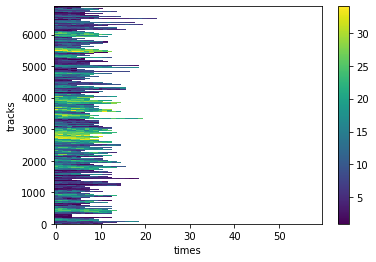

In [20]:
# plt.pcolormesh(ncells_domain, vmax=30)
# plt.colorbar()
ncells_domain.plot()

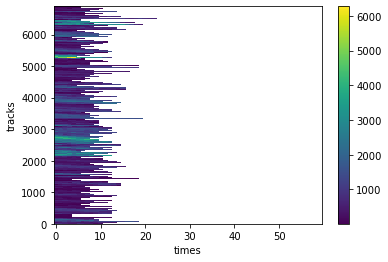

In [21]:
# plt.pcolormesh(cellarea_domain)
# plt.colorbar()
cellarea_domain.plot()

In [22]:
# Get max value over lifetime
max_eth30 = eth30.max(dim='times')
max_dbz = stats.max_dbz.max(dim='times')

eth_bins = np.arange(0,21,1)
dbz_bins = np.arange(10,75.1,5)
quantiles_2Dvar = [0.25,0.5,0.75]

max_dbz_ns, bins = np.histogram(max_dbz, bins=dbz_bins, density=False)
max_eth30_ns, bins = np.histogram(max_eth30, bins=eth_bins, density=False)

nquantiles = len(quantiles_2Dvar)
maxETH30_cape_pts = np.full((len(eth_bins)-1, nquantiles), np.nan, dtype=float)
maxdbz_cape_pts = np.full((len(dbz_bins)-1, nquantiles), np.nan, dtype=float)

maxETH30_cape_avg = np.full(len(eth_bins)-1, np.nan, dtype=float)
maxdbz_cape_avg = np.full(len(dbz_bins)-1, np.nan, dtype=float)
for ibin in range(len(eth_bins)-1):
    maxETH30_cape_pts[ibin,:] = cape.where((max_eth30 >= eth_bins[ibin]) & (max_eth30 < eth_bins[ibin+1]), drop=True).quantile(quantiles_2Dvar, skipna=True)
    maxETH30_cape_avg[ibin] = cape.where((max_eth30 >= eth_bins[ibin]) & (max_eth30 < eth_bins[ibin+1]), drop=True).mean()

for ibin in range(len(dbz_bins)-1):
    maxdbz_cape_pts[ibin,:] = cape.where((max_dbz >= dbz_bins[ibin]) & (max_dbz < dbz_bins[ibin+1]), drop=True).quantile(quantiles_2Dvar, skipna=True)
    maxdbz_cape_avg[ibin] = cape.where((max_dbz >= dbz_bins[ibin]) & (max_dbz < dbz_bins[ibin+1]), drop=True).mean()
    
# plt.plot(eth_bins[:-1], cape_eth30)

In [23]:
cape_bins = np.arange(0,4001,200)

cape_ns, bins = np.histogram(cape, bins=cape_bins, density=False)

cape_maxETH30_pts = np.full((len(cape_bins)-1, nquantiles), np.nan, dtype=float)

cape_maxETH30_avg = np.full(len(cape_bins)-1, np.nan, dtype=float)
for ibin in range(len(cape_bins)-1):
    cape_maxETH30_pts[ibin,:] = max_eth30.where((cape >= cape_bins[ibin]) & (cape < cape_bins[ibin+1]), drop=True).quantile(quantiles_2Dvar, skipna=True)
    cape_maxETH30_avg[ibin] = max_eth30.where((cape >= cape_bins[ibin]) & (cape < cape_bins[ibin+1]), drop=True).mean()

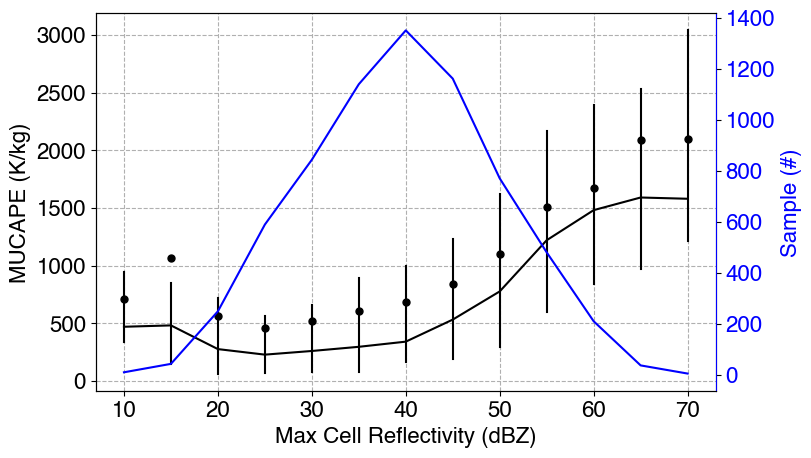

In [24]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Helvetica'
fig, axes = plt.subplots(1, 1, figsize=(8, 5), dpi=100)

ax1 = axes
ax1.plot(dbz_bins[:-1], maxdbz_cape_pts[:,1], color='k')
for ibin in range(len(dbz_bins)-1):
    ax1.plot((dbz_bins[ibin],dbz_bins[ibin]), maxdbz_cape_pts[ibin,(0,2)], color='k')
ax1.plot(dbz_bins[:-1], maxdbz_cape_avg, 'o', color='k', markersize=5)
ax1.set_xlabel('Max Cell Reflectivity (dBZ)')
ax1.set_ylabel('MUCAPE (K/kg)')
ax1.grid(ls='--')

ax2 = ax1.twinx()
ax2.plot(dbz_bins[:-1], max_dbz_ns, color='b')
ax2.set_ylabel('Sample (#)', color='b')
# ax2.set_ylim(4, 18)
ax2.tick_params(axis='y', labelcolor='b')
ax2.spines['right'].set_color('b')

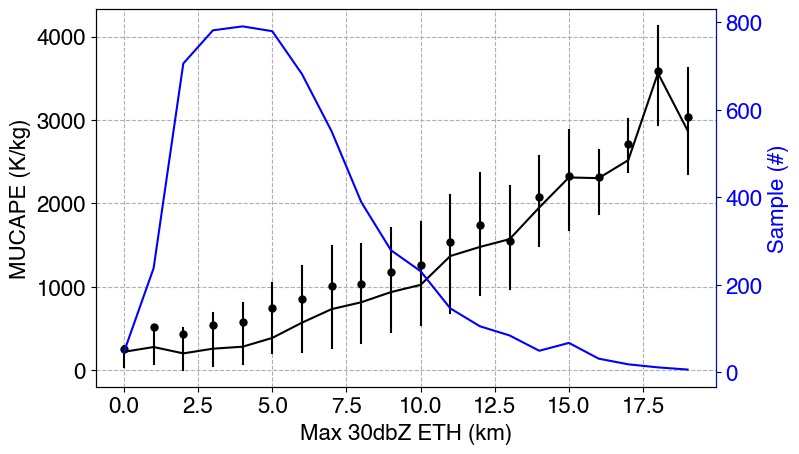

In [25]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Helvetica'
fig, axes = plt.subplots(1, 1, figsize=(8, 5), dpi=100)

ax1 = axes
# ax1.errorbar(eth_bins[:-1], maxETH30_cape_pts[:,1], yerr=maxETH30_cape_pts[:,(0,2)].transpose(), color='k')
ax1.plot(eth_bins[:-1], maxETH30_cape_pts[:,1], color='k')
for ibin in range(len(eth_bins)-1):
    ax1.plot((eth_bins[ibin],eth_bins[ibin]), maxETH30_cape_pts[ibin,(0,2)], color='k')
ax1.plot(eth_bins[:-1], maxETH30_cape_avg, 'o', color='k', markersize=5)
ax1.set_xlabel('Max 30dbZ ETH (km)')
ax1.set_ylabel('MUCAPE (K/kg)')
ax1.grid(ls='--')

ax2 = ax1.twinx()
ax2.plot(eth_bins[:-1], max_eth30_ns, color='b')
ax2.set_ylabel('Sample (#)', color='b')
# ax2.set_ylim(4, 18)
ax2.tick_params(axis='y', labelcolor='b')
ax2.spines['right'].set_color('b')

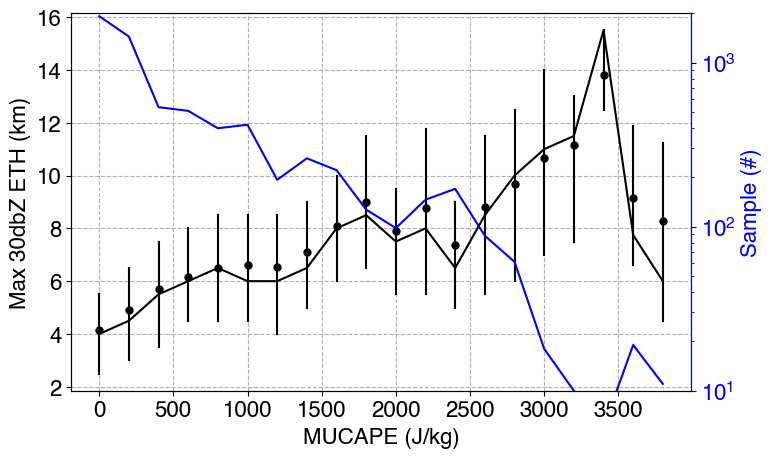

In [26]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Helvetica'
fig, axes = plt.subplots(1, 1, figsize=(8, 5), dpi=100)

ax1 = axes
ax1.plot(cape_bins[:-1], cape_maxETH30_pts[:,1], color='k')
for ibin in range(len(cape_bins)-1):
    ax1.plot((cape_bins[ibin],cape_bins[ibin]), cape_maxETH30_pts[ibin,(0,2)], color='k')
ax1.plot(cape_bins[:-1], cape_maxETH30_avg, 'o', color='k', markersize=5)
ax1.set_xlabel('MUCAPE (J/kg)')
ax1.set_ylabel('Max 30dbZ ETH (km)')
ax1.grid(ls='--')

ax2 = ax1.twinx()
ax2.plot(cape_bins[:-1], cape_ns, color='b')
ax2.set_ylabel('Sample (#)', color='b')
ax2.set_ylim(10, 2000)
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='b')
ax2.spines['right'].set_color('b')

In [27]:
# Find tracks initiation east of SDC during the day (12PM - 8PM)
# LT = UTC + 3
# Approximate longitude of SDC ridge
lon_SDC = -64.9
lon_eSDC = [-64.9, -63.]
# Day/night hour range in UTC
UTChour_day = [15,22]
UTChour_night = [0,8]

# cape_range1 = [50,500]
# cape_range2 = [500,1500]
# cape_range3 = [1500,4000]
cape_range1 = [50,400]
cape_range2 = [400,900]
cape_range3 = [900,4000]

cell_area1_cape = stats.cell_area.where((start_lon >= lon_SDC) & 
                                        (cape > cape_range1[0]) & (cape <= cape_range1[1]) & np.isnan(end_merge_tracknumber) & (np.isnan(start_split_tracknumber)), drop=True)
cell_area2_cape = stats.cell_area.where((start_lon >= lon_SDC) & 
                                        (cape > cape_range2[0]) & (cape <= cape_range2[1]) & np.isnan(end_merge_tracknumber) & (np.isnan(start_split_tracknumber)), drop=True)
cell_area3_cape = stats.cell_area.where((start_lon >= lon_SDC) & 
                                        (cape > cape_range3[0]) & (cape <= cape_range3[1]) & np.isnan(end_merge_tracknumber) & (np.isnan(start_split_tracknumber)), drop=True)
ntracks1_cape = cell_area1_cape.sizes['tracks']
ntracks2_cape = cell_area2_cape.sizes['tracks']
ntracks3_cape = cell_area3_cape.sizes['tracks']
print(f'Number of tracks: {ntracks1_cape}, {ntracks2_cape}, {ntracks3_cape}')

# max_dbz1_cape = stats.max_reflectivity.where((start_lon >= lon_SDC) & 
#                                              (cape > cape_range1[0]) & (cape <= cape_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)

Number of tracks: 874, 465, 579


(array([0.58279958, 1.32539818, 1.1091992 , 0.85539938, 0.58279958,
        0.43239969, 0.30079939, 0.1409999 , 0.10339993, 0.00939999]),
 array([1.1383027, 1.3220385, 1.5057745, 1.6895103, 1.8732462, 2.056982 ,
        2.240718 , 2.424454 , 2.6081898, 2.7919257, 2.9756615],
       dtype=float32),
 <BarContainer object of 10 artists>)

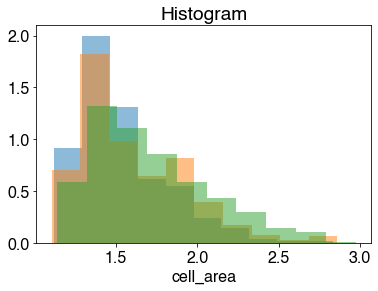

In [28]:
np.log10(cell_area1_cape.max(dim='times')).plot.hist(density=True, alpha=0.5)
np.log10(cell_area2_cape.max(dim='times')).plot.hist(density=True, alpha=0.5)
np.log10(cell_area3_cape.max(dim='times')).plot.hist(density=True, alpha=0.5)

In [29]:
# bin_cellarea = np.linspace(1, 3, 20)
# bin_maxdbz = np.linspace(10, 70, 20)
# bin_ctt = np.linspace(175,280,20)
# bin_eth = np.linspace(0,20,21)
# bin_cth = np.linspace(0,20,21)
# bin_tir = np.linspace(180,300,21)
# bin_ctp = np.linspace(80,900,21)
bin_cellarea = np.arange(1, 3.01, 0.1)
bin_maxdbz = np.arange(10, 70.1, 2.5)
bin_ctt = np.arange(-100,10.1,5)
bin_eth = np.arange(0,20.1,1)
bin_cth = np.arange(0,20.1,1)
bin_tir = np.arange(180,300.1,5)
bin_ctp = np.arange(50,900.1,50)

# Convert CTT unit from Kelvin to Celsius for easier interpretation
ctt_celsius = stats.cloud_top_temperature_min - 273.15

# hist2d_cellarea_maxdbz, bin_cellarea, bin_maxdbz = np.histogram2d(np.log10(stats.cell_area).max(dim='times'), stats.max_dbz.max(dim='times'), bins=20)
hist2d_cellarea_maxdbz, xbin, ybin = np.histogram2d(np.log10(stats.cell_area).max(dim='times'), stats.max_dbz.max(dim='times'), bins=[bin_cellarea, bin_maxdbz])
hist2d_minctt_maxdbz, xbin, ybin = np.histogram2d(ctt_celsius.min(dim='times'), stats.max_dbz.max(dim='times'), bins=[bin_ctt, bin_maxdbz])
hist2d_eth20_maxdbz, xbin, ybin = np.histogram2d(stats.maxETH_20dbz.max(dim='times'), stats.max_dbz.max(dim='times'), bins=[bin_eth, bin_maxdbz])
hist2d_cellarea_eth20, xbin, ybin = np.histogram2d(np.log10(stats.cell_area).max(dim='times'), stats.maxETH_20dbz.max(dim='times'), bins=[bin_cellarea, bin_eth])
hist2d_maxcth_maxdbz, xbin, ybin = np.histogram2d(stats.cloud_top_height_max.max(dim='times'), stats.max_dbz.max(dim='times'), bins=[bin_cth, bin_maxdbz])
hist2d_mintir_maxdbz, xbin, ybin = np.histogram2d(stats.temperature_ir_min.min(dim='times'), stats.max_dbz.max(dim='times'), bins=[bin_tir, bin_maxdbz])
hist2d_minctp_maxdbz, xbin, ybin = np.histogram2d(stats.cloud_top_pressure_min.min(dim='times'), stats.max_dbz.max(dim='times'), bins=[bin_ctp, bin_maxdbz])

hist2d_cellarea_maxcth, xbin, ybin = np.histogram2d(np.log10(stats.cell_area).max(dim='times'), stats.cloud_top_height_max.max(dim='times'), bins=[bin_cellarea, bin_cth])
hist2d_cellarea_minctt, xbin, ybin = np.histogram2d(np.log10(stats.cell_area).max(dim='times'), ctt_celsius.min(dim='times'), bins=[bin_cellarea, bin_ctt])
hist2d_cellarea_mintir, xbin, ybin = np.histogram2d(np.log10(stats.cell_area).max(dim='times'), stats.temperature_ir_min.min(dim='times'), bins=[bin_cellarea, bin_tir])
hist2d_cellarea_minctp, xbin, ybin = np.histogram2d(np.log10(stats.cell_area).max(dim='times'), stats.cloud_top_pressure_min.min(dim='times'), bins=[bin_cellarea, bin_ctp])

In [30]:
bin_ctp

array([ 50., 100., 150., 200., 250., 300., 350., 400., 450., 500., 550.,
       600., 650., 700., 750., 800., 850., 900.])

In [31]:
def plot_jointhist_4panel(data_arr, xbins, ybins, cmap, xlabels, ylabels, xticks, yticks, titles, cblabels, figname, levels=None):

    mpl.rcParams['font.size'] = 13
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['figure.facecolor'] = 'white'
    fig, axes = plt.subplots(2, 2, figsize=(10, 8.5), dpi=100)
    cmap = plt.get_cmap(cmap)
    
    for row in range(2):
        for col in range(2):
            ax = axes[row, col]
            Zm = np.ma.masked_where(data_arr[row][col] <= 0, data_arr[row][col])
#             # Normalize colormap
#             if normal is not None:
#                 norm = mpl.colors.LogNorm(vmin=Zm.min(), vmax=Zm.max())
#             else:
#                 norm = None
            if levels is not None:
                norm = mpl.colors.BoundaryNorm(levels[row][col], ncolors=cmap.N)
            else:
                norm = None
            pcm = ax.pcolormesh(xbins[row][col], ybins[row][col], Zm, norm=norm, cmap=cmap, shading='auto')
            cb = plt.colorbar(pcm, ax=ax, label=cblabels[row][col])
            ax.grid(ls='--')
            ax.set_xlabel(xlabels[row][col])
            ax.set_ylabel(ylabels[row][col])
            ax.set_title(titles[row][col], loc='left')
            ax.set_xticks(xticks[row][col])
            ax.set_yticks(yticks[row][col])
    
    fig.tight_layout()
    fig.savefig(figname, bbox_inches='tight', dpi=300)
    
    return fig

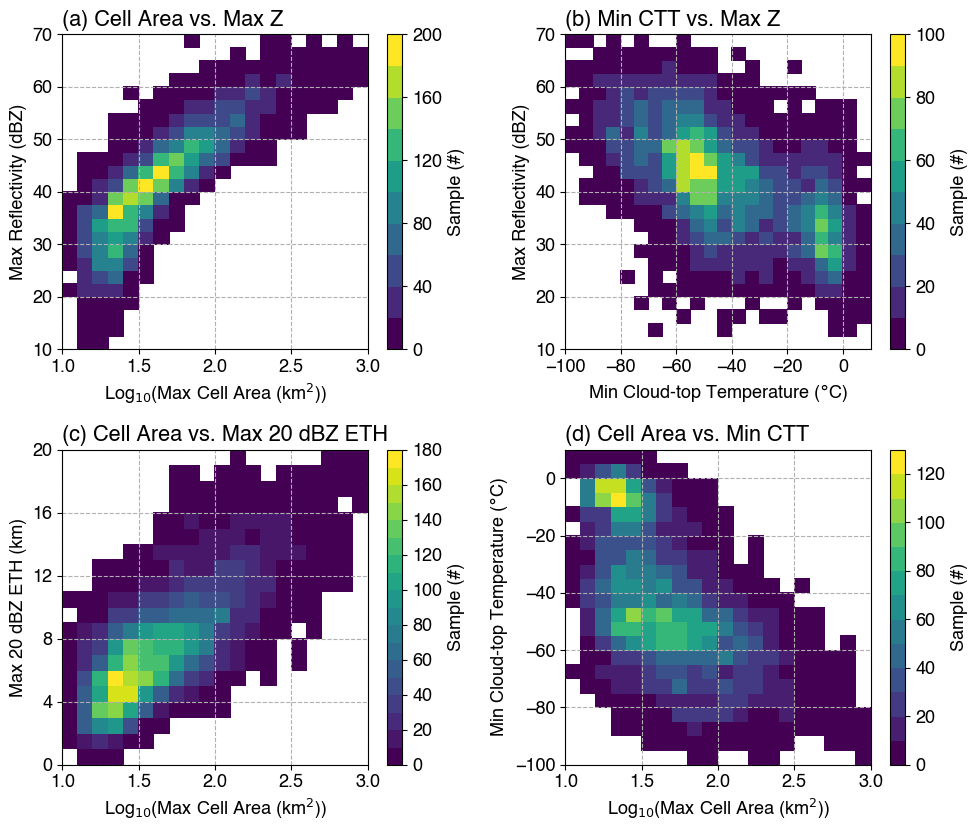

In [32]:
data_arr = [[hist2d_cellarea_maxdbz.transpose(), hist2d_minctt_maxdbz.transpose()], 
            [hist2d_cellarea_eth20.transpose(), hist2d_cellarea_minctt.transpose(), ]]
xbins = [[bin_cellarea, bin_ctt],[bin_cellarea, bin_cellarea]]
ybins = [[bin_maxdbz, bin_maxdbz], [bin_eth, bin_ctt]]
ticks_cellarea = np.arange(1.0, 3.1, 0.5)
ticks_maxdbz = np.arange(10, 71, 10)
ticks_eth = np.arange(0, 20.1, 4)
ticks_ctt = np.arange(-100, 0.1, 20)
xticks = [[ticks_cellarea, ticks_ctt],
          [ticks_cellarea, ticks_cellarea]]
yticks = [[ticks_maxdbz, ticks_maxdbz],
          [ticks_eth, ticks_ctt]]
levels = [[np.arange(0,201,20), np.arange(0,101,10)], 
          [np.arange(0,181,10), np.arange(0,131,10)]]
cmap = 'viridis'
xlabels = [['Log$_{10}$(Max Cell Area (km$^2$))', 'Min Cloud-top Temperature ($\degree$C)'], ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))']]
ylabels = [['Max Reflectivity (dBZ)', 'Max Reflectivity (dBZ)'], ['Max 20 dBZ ETH (km)', 'Min Cloud-top Temperature ($\degree$C)']]
titles = [['(a) Cell Area vs. Max Z', '(b) Min CTT vs. Max Z'], 
          ['(c) Cell Area vs. Max 20 dBZ ETH', '(d) Cell Area vs. Min CTT']]
cblabels = [['Sample (#)', 'Sample (#)'], ['Sample (#)', 'Sample (#)']]
figname = f'{figdir_jointhist}JointHist_MaxDBZ_vs_CellStats2.png'
fig = plot_jointhist_4panel(data_arr, xbins, ybins, cmap, xlabels, ylabels, xticks, yticks, titles, cblabels, figname, levels=levels)

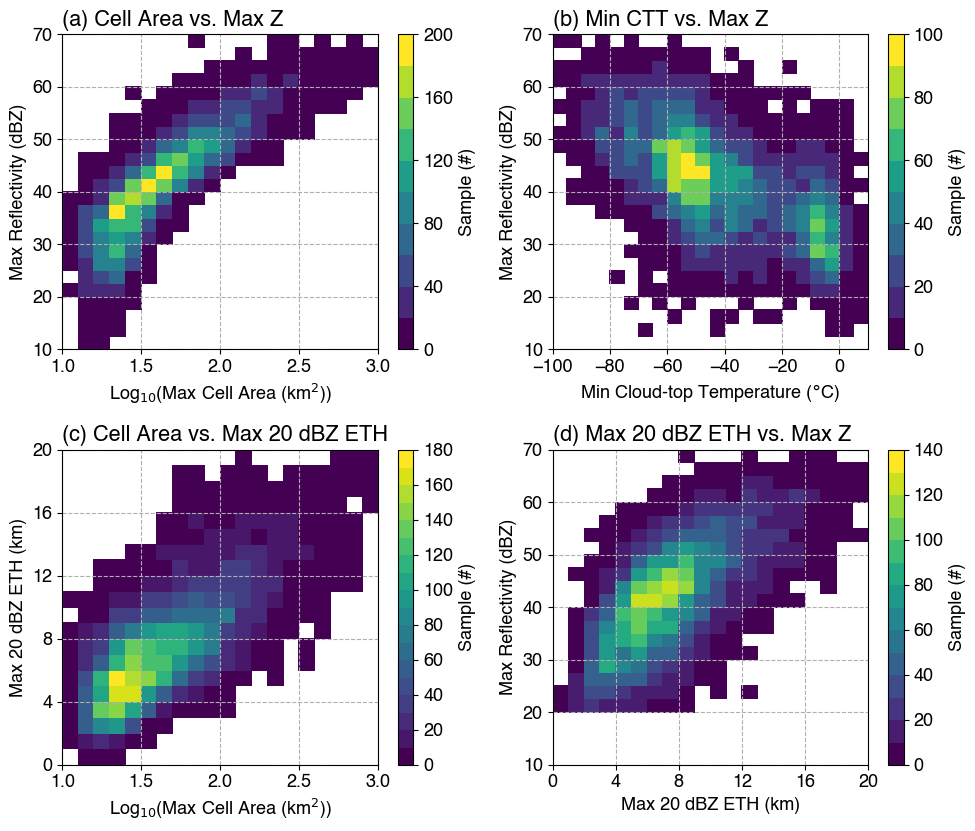

In [33]:
data_arr = [[hist2d_cellarea_maxdbz.transpose(), hist2d_minctt_maxdbz.transpose()], 
            [hist2d_cellarea_eth20.transpose(), hist2d_eth20_maxdbz.transpose(), ]]
xbins = [[bin_cellarea, bin_ctt],[bin_cellarea, bin_eth]]
ybins = [[bin_maxdbz, bin_maxdbz], [bin_eth, bin_maxdbz]]
xticks = [[ticks_cellarea, ticks_ctt],
          [ticks_cellarea, ticks_eth]]
yticks = [[ticks_maxdbz, ticks_maxdbz],
          [ticks_eth, ticks_maxdbz]]
levels = [[np.arange(0,201,20), np.arange(0,101,10)], 
          [np.arange(0,181,10), np.arange(0,141,10)]]
cmap = 'viridis'
xlabels = [['Log$_{10}$(Max Cell Area (km$^2$))', 'Min Cloud-top Temperature ($\degree$C)'], ['Log$_{10}$(Max Cell Area (km$^2$))', 'Max 20 dBZ ETH (km)']]
ylabels = [['Max Reflectivity (dBZ)', 'Max Reflectivity (dBZ)'], ['Max 20 dBZ ETH (km)', 'Max Reflectivity (dBZ)']]
titles = [['(a) Cell Area vs. Max Z', '(b) Min CTT vs. Max Z'], 
          ['(c) Cell Area vs. Max 20 dBZ ETH', '(d) Max 20 dBZ ETH vs. Max Z']]
cblabels = [['Sample (#)', 'Sample (#)'], ['Sample (#)', 'Sample (#)']]
figname = f'{figdir_jointhist}JointHist_MaxDBZ_vs_CellStats.png'
fig = plot_jointhist_4panel(data_arr, xbins, ybins, cmap, xlabels, ylabels, xticks, yticks, titles, cblabels, figname, levels=levels)

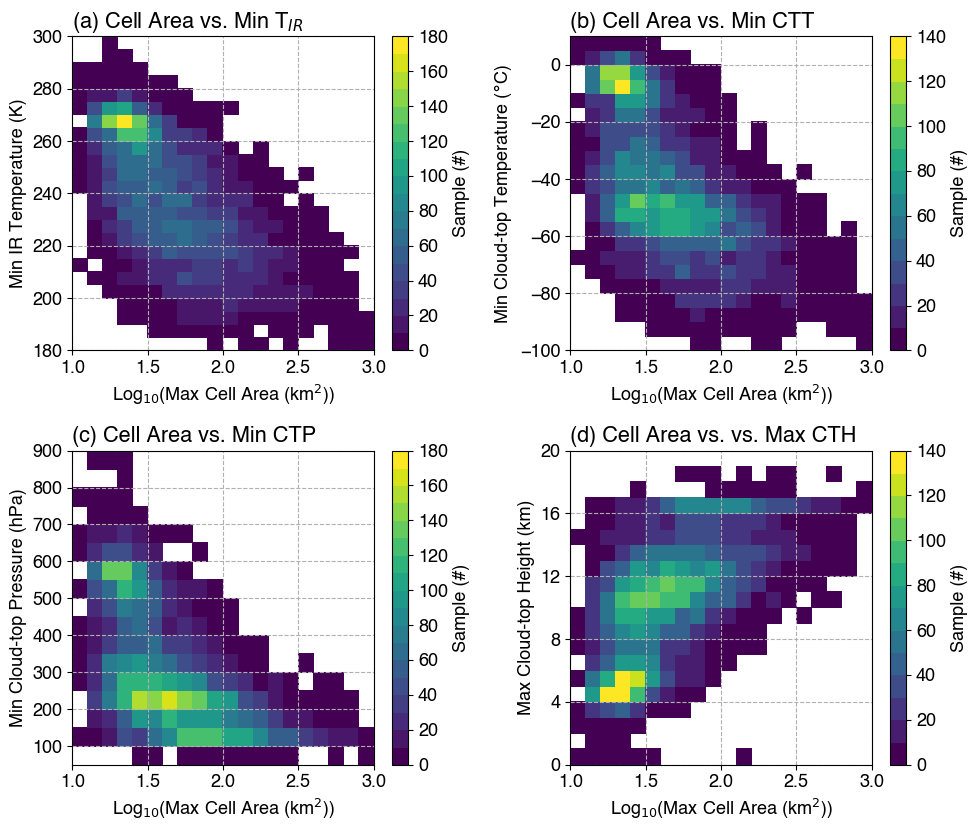

In [34]:
data_arr = [[hist2d_cellarea_mintir.transpose(), hist2d_cellarea_minctt.transpose()], 
            [hist2d_cellarea_minctp.transpose(), hist2d_cellarea_maxcth.transpose(), ]]
xbins = [[bin_cellarea, bin_cellarea], [bin_cellarea, bin_cellarea]]
ybins = [[bin_tir, bin_ctt],[bin_ctp, bin_cth]]
ticks_tir = np.arange(180, 301, 20)
ticks_ctp = np.arange(100, 901, 100)
ticks_cth = np.arange(0, 20.1, 4)
xticks = [[ticks_cellarea, ticks_cellarea],
          [ticks_cellarea, ticks_cellarea]]
yticks = [[ticks_tir, ticks_ctt],
          [ticks_ctp, ticks_cth]]
levels = [[np.arange(0,181,10), np.arange(0,141,10)], 
          [np.arange(0,181,10), np.arange(0,141,10)]]
cmap = 'viridis'
xlabels = [['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))'], 
           ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))']]
ylabels = [['Min IR Temperature (K)', 'Min Cloud-top Temperature ($\degree$C)'], ['Min Cloud-top Pressure (hPa)', 'Max Cloud-top Height (km)']]
titles = [['(a) Cell Area vs. Min T$_{IR}$', '(b) Cell Area vs. Min CTT'], 
          ['(c) Cell Area vs. Min CTP', '(d) Cell Area vs. vs. Max CTH']]
cblabels = [['Sample (#)', 'Sample (#)'], ['Sample (#)', 'Sample (#)']]
figname = f'{figdir_jointhist}JointHist_MaxCellArea_vs_GOESCloudTopStats.png'
fig = plot_jointhist_4panel(data_arr, xbins, ybins, cmap, xlabels, ylabels, xticks, yticks, titles, cblabels, figname, levels=levels)
# figname = f'{figdir_jointhist}JointHist_MaxCellArea_vs_GOESCloudTopStats_LogScale.png'
# fig = plot_jointhist_4panel(data_arr, xbins, ybins, cmap, xlabels, ylabels, titles, cblabels, figname, normal=True)

In [35]:
hist2d_minctp_maxdbz.transpose().shape, bin_ctp.shape, bin_maxdbz.shape

((24, 17), (18,), (25,))

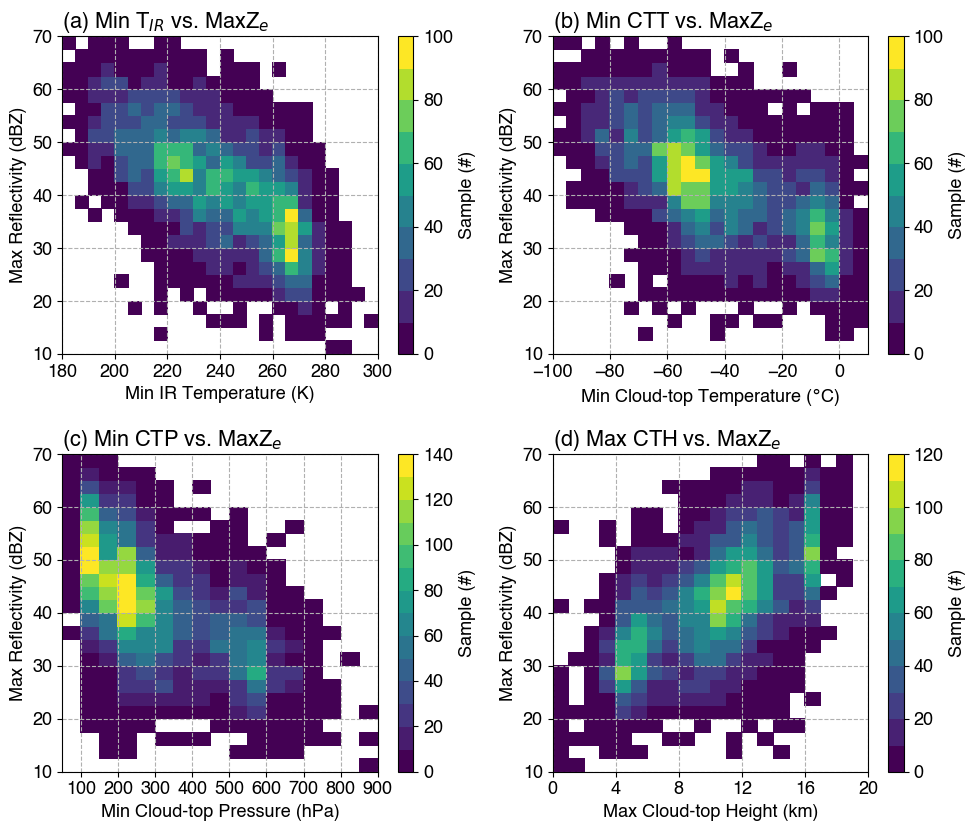

In [36]:
data_arr = [[hist2d_mintir_maxdbz.transpose(), hist2d_minctt_maxdbz.transpose()], 
            [hist2d_minctp_maxdbz.transpose(), hist2d_maxcth_maxdbz.transpose(), ]]
xbins = [[bin_tir, bin_ctt], [bin_ctp, bin_cth]]
ybins = [[bin_maxdbz, bin_maxdbz], [bin_maxdbz, bin_maxdbz]]
xticks = [[ticks_tir, ticks_ctt],
          [ticks_ctp, ticks_cth]]
yticks = [[ticks_maxdbz, ticks_maxdbz],
          [ticks_maxdbz, ticks_maxdbz]]
levels = [[np.arange(0,101,10), np.arange(0,101,10)], 
          [np.arange(0,141,10), np.arange(0,121,10)]]
cmap = 'viridis'
xlabels = [['Min IR Temperature (K)', 'Min Cloud-top Temperature ($\degree$C)'], ['Min Cloud-top Pressure (hPa)', 'Max Cloud-top Height (km)']]
ylabels = [['Max Reflectivity (dBZ)', 'Max Reflectivity (dBZ)'], ['Max Reflectivity (dBZ)', 'Max Reflectivity (dBZ)']]
titles = [['(a) Min T$_{IR}$ vs. MaxZ$_e$', '(b) Min CTT vs. MaxZ$_e$'], 
          ['(c) Min CTP vs. MaxZ$_e$', '(d) Max CTH vs. MaxZ$_e$']]
cblabels = [['Sample (#)', 'Sample (#)'], ['Sample (#)', 'Sample (#)']]
figname = f'{figdir_jointhist}JointHist_MaxDBZ_vs_GOESCloudTopStats.png'
fig = plot_jointhist_4panel(data_arr, xbins, ybins, cmap, xlabels, ylabels, xticks, yticks, titles, cblabels, figname, levels=levels)
# figname = f'{figdir_jointhist}JointHist_MaxDBZ_vs_CellStats_LogScale.png'
# fig = plot_jointhist_4panel(data_arr, xbins, ybins, cmap, xlabels, ylabels, titles, cblabels, figname, normal=True)

In [37]:
def stdv1d_by2cond(in_var, x_cond_var, x_cond_range, y_cond_var, y_cond_range, 
                   loc_var, loc_range, min_nsample=5):
    nbins_x = len(x_cond_range)-1
    nbins_y = len(y_cond_range)-1
    out_var_std = np.full((nbins_y, nbins_x), np.nan, dtype=float)
    nsamples = np.full((nbins_y, nbins_x), 0, dtype=np.int32)
    # Loop over two conditional variable bins
    for xbin in range(nbins_x):
        for ybin in range(nbins_y):
            in_var_cond = in_var.where((loc_var >= loc_range[0]) & (loc_var <= loc_range[1]) &
                                       (x_cond_var > x_cond_range[xbin]) & (x_cond_var <= x_cond_range[xbin+1]) &
                                       (y_cond_var > y_cond_range[ybin]) & (y_cond_var <= y_cond_range[ybin+1]), drop=True)
            nsamples[ybin, xbin] = in_var_cond.sizes['tracks']
            if nsamples[ybin, xbin] >= min_nsample:
                out_var_std[ybin, xbin] = in_var_cond.std(dim='tracks', skipna=True).values
    return (nsamples, out_var_std)

In [38]:
def quantiles1d_by2cond(in_var, x_cond_var, x_cond_range, y_cond_var, y_cond_range, 
                       loc_var, loc_range, quantiles, min_nsample=5):
    nbins_x = len(x_cond_range)-1
    nbins_y = len(y_cond_range)-1
    npts = len(quantiles)
    out_var_pts = np.full((npts, nbins_y, nbins_x), np.nan, dtype=float)
    out_var_avg = np.full((nbins_y, nbins_x), np.nan, dtype=float)
    nsamples = np.full((nbins_y, nbins_x), 0, dtype=np.int32)
    # Loop over two conditional variable bins
    for xbin in range(nbins_x):
        for ybin in range(nbins_y):
#             in_var_cond = in_var.where((loc_var >= loc_range[0]) & (loc_var <= loc_range[1]) &
#                                        (x_cond_var > x_cond_range[xbin]) & (x_cond_var <= x_cond_range[xbin+1]) &
#                                        (y_cond_var > y_cond_range[ybin]) & (y_cond_var <= y_cond_range[ybin+1]) &
#                                        (np.isnan(merge_tracknumber)) & (np.isnan(split_tracknumber)), drop=True)
            in_var_cond = in_var.where((loc_var >= loc_range[0]) & (loc_var <= loc_range[1]) &
                                       (x_cond_var > x_cond_range[xbin]) & (x_cond_var <= x_cond_range[xbin+1]) &
                                       (y_cond_var > y_cond_range[ybin]) & (y_cond_var <= y_cond_range[ybin+1]), drop=True)
            nsamples[ybin, xbin] = in_var_cond.sizes['tracks']
            if nsamples[ybin, xbin] >= min_nsample:
                out_var_pts[:, ybin, xbin] = in_var_cond.quantile(quantiles, dim='tracks', skipna=True).values
                out_var_avg[ybin, xbin] = in_var_cond.mean(dim='tracks').values
    return (nsamples, out_var_pts, out_var_avg)

In [39]:
def quantiles2d_by2cond(in_var, x_cond_var, x_cond_range, y_cond_var, y_cond_range, 
                       loc_var, loc_range, quantiles, min_nsample=5):
    nbins_x = len(x_cond_range)-1
    nbins_y = len(y_cond_range)-1
    npts = len(quantiles)
    out_var_pts = np.full((npts, nbins_y, nbins_x), np.nan, dtype=float)
    out_var_avg = np.full((nbins_y, nbins_x), np.nan, dtype=float)
    nsamples = np.full((nbins_y, nbins_x), 0, dtype=np.int32)
#     print(nsamples.shape)
    # Loop over two conditional variable bins
    for xbin in range(nbins_x):
        for ybin in range(nbins_y):
#             print(xbin, ybin)
#             in_var_cond = in_var.where((loc_var >= loc_range[0]) & (loc_var <= loc_range[1]) &
#                                        (x_cond_var > x_cond_range[xbin]) & (x_cond_var <= x_cond_range[xbin+1]) &
#                                        (y_cond_var > y_cond_range[ybin]) & (y_cond_var <= y_cond_range[ybin+1]) &
#                                        (np.isnan(merge_tracknumber)) & (np.isnan(split_tracknumber)), drop=True)
            in_var_cond = in_var.where((loc_var >= loc_range[0]) & (loc_var <= loc_range[1]) &
                                       (x_cond_var > x_cond_range[xbin]) & (x_cond_var <= x_cond_range[xbin+1]) &
                                       (y_cond_var > y_cond_range[ybin]) & (y_cond_var <= y_cond_range[ybin+1]), drop=True)
            nsamples[ybin, xbin] = in_var_cond.sizes['tracks']
            if nsamples[ybin, xbin] >= min_nsample:
                out_var_pts[:, ybin, xbin] = in_var_cond.max(dim='times').quantile(quantiles, dim='tracks', skipna=True).values
                out_var_avg[ybin, xbin] = in_var_cond.max(dim='times').mean(dim='tracks').values
    return (nsamples, out_var_pts, out_var_avg)

In [40]:
quantiles_2d = [0.25,0.5,0.75,0.9,0.95]

# Calculate single environment parameter stats as joint functions of cell statistics
# Get lifetime max cell statistics
max_cellarea_lifetime = np.log10(stats.cell_area).max(dim='times')
max_dbz_lifetime = stats.max_dbz.max(dim='times')
max_eth20_lifetime = stats.maxETH_20dbz.max(dim='times')
max_eth30_lifetime = stats.maxETH_30dbz.max(dim='times')
# min_ctt_lifetime = stats.cloud_top_temperature_min.min(dim='times')
min_ctt_lifetime = ctt_celsius.min(dim='times')
ncells_domain_lifetime = ncells_domain.mean(dim='times')
cellarea_domain_lifetime = cellarea_domain.mean(dim='times')
ncells_domain_init = ncells_domain.isel(times=0)
cellarea_domain_init = cellarea_domain.isel(times=0)

# Set min number of samples in each bin
min_ns = 5
nsamples_cellareamaxdbz, cape_cellareamaxdbz_pts, cape_cellareamaxdbz_avg = quantiles1d_by2cond(cape, max_cellarea_lifetime, bin_cellarea, max_dbz_lifetime, bin_maxdbz, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareamaxdbz, lnb_z_cellareamaxdbz_pts, lnb_z_cellareamaxdbz_avg = quantiles1d_by2cond(lnb_z, max_cellarea_lifetime, bin_cellarea, max_dbz_lifetime, bin_maxdbz, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareamaxdbz, cin_cellareamaxdbz_pts, cin_cellareamaxdbz_avg = quantiles1d_by2cond(cin, max_cellarea_lifetime, bin_cellarea, max_dbz_lifetime, bin_maxdbz, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareamaxdbz, lfc_z_cellareamaxdbz_pts, lfc_z_cellareamaxdbz_avg = quantiles1d_by2cond(lfc_z, max_cellarea_lifetime, bin_cellarea, max_dbz_lifetime, bin_maxdbz, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareamaxdbz, lpl_z_cellareamaxdbz_pts, lpl_z_cellareamaxdbz_avg = quantiles1d_by2cond(lpl_z, max_cellarea_lifetime, bin_cellarea, max_dbz_lifetime, bin_maxdbz, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareamaxdbz, q850p_cellareamaxdbz_pts, q850p_cellareamaxdbz_avg = quantiles1d_by2cond(q850p, max_cellarea_lifetime, bin_cellarea, max_dbz_lifetime, bin_maxdbz, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareamaxdbz, q700p_cellareamaxdbz_pts, q700p_cellareamaxdbz_avg = quantiles1d_by2cond(q700p, max_cellarea_lifetime, bin_cellarea, max_dbz_lifetime, bin_maxdbz, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareamaxdbz, rh700p_cellareamaxdbz_pts, rh700p_cellareamaxdbz_avg = quantiles1d_by2cond(rh700p, max_cellarea_lifetime, bin_cellarea, max_dbz_lifetime, bin_maxdbz, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareamaxdbz, rh500p_cellareamaxdbz_pts, rh500p_cellareamaxdbz_avg = quantiles1d_by2cond(rh500p, max_cellarea_lifetime, bin_cellarea, max_dbz_lifetime, bin_maxdbz, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareamaxdbz, ncells_cellareamaxdbz_pts, ncells_cellareamaxdbz_avg = quantiles1d_by2cond(ncells_domain_lifetime, max_cellarea_lifetime, bin_cellarea, max_dbz_lifetime, bin_maxdbz, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareamaxdbz, totalcellarea_cellareamaxdbz_pts, totalcellarea_cellareamaxdbz_avg = quantiles1d_by2cond(cellarea_domain_lifetime, max_cellarea_lifetime, bin_cellarea, max_dbz_lifetime, bin_maxdbz, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareamaxdbz, ncellsInit_cellareamaxdbz_pts, ncellsInit_cellareamaxdbz_avg = quantiles1d_by2cond(ncells_domain_init, max_cellarea_lifetime, bin_cellarea, max_dbz_lifetime, bin_maxdbz, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareamaxdbz, totalcellareaInit_cellareamaxdbz_pts, totalcellareaInit_cellareamaxdbz_avg = quantiles1d_by2cond(cellarea_domain_init, max_cellarea_lifetime, bin_cellarea, max_dbz_lifetime, bin_maxdbz, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


In [41]:
np.sum(nsamples_cellareamaxdbz)

4272

In [42]:
nsamples_cellareaeth20, cape_cellareaeth20_pts, cape_cellareaeth20_avg = quantiles1d_by2cond(cape, max_cellarea_lifetime, bin_cellarea, max_eth20_lifetime, bin_eth, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareaeth20, lnb_z_cellareaeth20_pts, lnb_z_cellareaeth20_avg = quantiles1d_by2cond(lnb_z, max_cellarea_lifetime, bin_cellarea, max_eth20_lifetime, bin_eth, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareaeth20, cin_cellareaeth20_pts, cin_cellareaeth20_avg = quantiles1d_by2cond(cin, max_cellarea_lifetime, bin_cellarea, max_eth20_lifetime, bin_eth, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareaeth20, lfc_z_cellareaeth20_pts, lfc_z_cellareaeth20_avg = quantiles1d_by2cond(lfc_z, max_cellarea_lifetime, bin_cellarea, max_eth20_lifetime, bin_eth, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareaeth20, lpl_z_cellareaeth20_pts, lpl_z_cellareaeth20_avg = quantiles1d_by2cond(lpl_z, max_cellarea_lifetime, bin_cellarea, max_eth20_lifetime, bin_eth, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareaeth20, q850p_cellareaeth20_pts, q850p_cellareaeth20_avg = quantiles1d_by2cond(q850p, max_cellarea_lifetime, bin_cellarea, max_eth20_lifetime, bin_eth, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareaeth20, q700p_cellareaeth20_pts, q700p_cellareaeth20_avg = quantiles1d_by2cond(q700p, max_cellarea_lifetime, bin_cellarea, max_eth20_lifetime, bin_eth, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareaeth20, rh700p_cellareaeth20_pts, rh700p_cellareaeth20_avg = quantiles1d_by2cond(rh700p, max_cellarea_lifetime, bin_cellarea, max_eth20_lifetime, bin_eth, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareaeth20, rh500p_cellareaeth20_pts, rh500p_cellareaeth20_avg = quantiles1d_by2cond(rh500p, max_cellarea_lifetime, bin_cellarea, max_eth20_lifetime, bin_eth, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarnin

In [43]:
nsamples_cellareactt, cape_cellareactt_pts, cape_cellareactt_avg = quantiles1d_by2cond(cape, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareactt, lnb_z_cellareactt_pts, lnb_z_cellareactt_avg = quantiles1d_by2cond(lnb_z, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareactt, cin_cellareactt_pts, cin_cellareactt_avg = quantiles1d_by2cond(cin, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareactt, lfc_z_cellareactt_pts, lfc_z_cellareactt_avg = quantiles1d_by2cond(lfc_z, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareactt, lpl_z_cellareactt_pts, lpl_z_cellareactt_avg = quantiles1d_by2cond(lpl_z, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareactt, q850p_cellareactt_pts, q850p_cellareactt_avg = quantiles1d_by2cond(q850p, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareactt, q700p_cellareactt_pts, q700p_cellareactt_avg = quantiles1d_by2cond(q700p, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareactt, rh700p_cellareactt_pts, rh700p_cellareactt_avg = quantiles1d_by2cond(rh700p, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareactt, rh500p_cellareactt_pts, rh500p_cellareactt_avg = quantiles1d_by2cond(rh500p, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarnin

In [44]:
nsamples_cellareactt, shear3mag_cellareactt_pts, shear3mag_cellareactt_avg = quantiles1d_by2cond(shear3mag, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareactt, shear6mag_cellareactt_pts, shear6mag_cellareactt_avg = quantiles1d_by2cond(shear6mag, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareactt, u700p_cellareactt_pts, u700p_cellareactt_avg = quantiles1d_by2cond(u700p, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareactt, v700p_cellareactt_pts, v700p_cellareactt_avg = quantiles1d_by2cond(v700p, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareactt, u850p_cellareactt_pts, u850p_cellareactt_avg = quantiles1d_by2cond(u850p, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareactt, v850p_cellareactt_pts, v850p_cellareactt_avg = quantiles1d_by2cond(v850p, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

In [45]:
nsamples_cellareactt, shear9mag_cellareactt_pts, shear9mag_cellareactt_avg = quantiles1d_by2cond(shear9mag, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)
nsamples_cellareactt, shear12mag_cellareactt_pts, shear12mag_cellareactt_avg = quantiles1d_by2cond(shear12mag, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


In [46]:
bin_rh = np.arange(0,101,8)
bin_shear6mag = np.arange(4,48.1,4)
nsamples_rhshear, cellarea_rh500shear6mag_pts, cellarea_rh500shear6mag_avg = quantiles1d_by2cond(max_cellarea_lifetime, rh500p, bin_rh, shear6mag, bin_shear6mag, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)
nsamples_rhshear, ctt_rh500shear6mag_pts, ctt_rh500shear6mag_avg = quantiles1d_by2cond(min_ctt_lifetime, rh500p, bin_rh, shear6mag, bin_shear6mag, 
                                                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

In [47]:
nsamples_cellareactt, cape_cellareactt_std = stdv1d_by2cond(cape, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                              start_lon, lon_eSDC, min_nsample=min_ns)

nsamples_cellareactt, lnb_z_cellareactt_std = stdv1d_by2cond(lnb_z, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                              start_lon, lon_eSDC, min_nsample=min_ns)

nsamples_cellareactt, q850p_cellareactt_std = stdv1d_by2cond(q850p, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                              start_lon, lon_eSDC, min_nsample=min_ns)

nsamples_cellareactt, rh500p_cellareactt_std = stdv1d_by2cond(rh500p, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                              start_lon, lon_eSDC, min_nsample=min_ns)

nsamples_cellareactt, shear3mag_cellareactt_std = stdv1d_by2cond(shear3mag, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                              start_lon, lon_eSDC, min_nsample=min_ns)

nsamples_cellareactt, shear6mag_cellareactt_std = stdv1d_by2cond(shear6mag, max_cellarea_lifetime, bin_cellarea, min_ctt_lifetime, bin_ctt, 
                                                              start_lon, lon_eSDC, min_nsample=min_ns)

/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [48]:
max_dbz_lifetime_lnb6km = stats.max_dbz.where(lnb_z >= 6).max(dim='times')
max_eth20_lifetime_lnb6km = stats.maxETH_20dbz.where(lnb_z >= 6).max(dim='times')
max_eth30_lifetime_lnb6km = stats.maxETH_30dbz.where(lnb_z >= 6).max(dim='times')
max_cellarea_lifetime_lnb6km = np.log10(stats.cell_area.where(lnb_z >= 6)).max(dim='times')
# min_ctt_lifetime_lnb6km = stats.cloud_top_temperature_min.where(lnb_z >= 6).min(dim='times')
min_ctt_lifetime_lnb6km = ctt_celsius.where(lnb_z >= 6).min(dim='times')
cape_lnb6km = cape.where(lnb_z >= 6)
lnb_z_lnb6km = lnb_z.where(lnb_z >= 6)
cin_lnb6km = cin.where(lnb_z >= 6)
lfc_z_lnb6km = lfc_z.where(lnb_z >= 6)
lpl_z_lnb6km = lpl_z.where(lnb_z >= 6)
q850p_lnb6km = q850p.where(lnb_z >= 6)
q700p_lnb6km = q700p.where(lnb_z >= 6)
rh700p_lnb6km = rh700p.where(lnb_z >= 6)
rh500p_lnb6km = rh500p.where(lnb_z >= 6)
shear3mag_lnb6km = shear3mag.where(lnb_z >= 6)
shear6mag_lnb6km = shear6mag.where(lnb_z >= 6)
u700p_lnb6km = u700p.where(lnb_z >= 6)
v700p_lnb6km = v700p.where(lnb_z >= 6)
u850p_lnb6km = u850p.where(lnb_z >= 6)
v850p_lnb6km = v850p.where(lnb_z >= 6)

nsamples_cellareacttLNB6km, capeLNB6km_cellareactt_pts, \
capeLNB6km_cellareactt_avg = quantiles1d_by2cond(cape_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, min_ctt_lifetime_lnb6km, bin_ctt, 
                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareacttLNB6km, lnb_zLNB6km_cellareactt_pts, \
lnb_zLNB6km_cellareactt_avg = quantiles1d_by2cond(lnb_z_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, min_ctt_lifetime_lnb6km, bin_ctt, 
                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareacttLNB6km, cinLNB6km_cellareactt_pts, \
cinLNB6km_cellareactt_avg = quantiles1d_by2cond(cin_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, min_ctt_lifetime_lnb6km, bin_ctt, 
                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareacttLNB6km, lfc_zLNB6km_cellareactt_pts, \
lfc_zLNB6km_cellareactt_avg = quantiles1d_by2cond(lfc_z_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, min_ctt_lifetime_lnb6km, bin_ctt, 
                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareacttLNB6km, lpl_zLNB6km_cellareactt_pts, \
lpl_zLNB6km_cellareactt_avg = quantiles1d_by2cond(lpl_z_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, min_ctt_lifetime_lnb6km, bin_ctt, 
                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareacttLNB6km, q850pLNB6km_cellareactt_pts, \
q850pLNB6km_cellareactt_avg = quantiles1d_by2cond(q850p_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, min_ctt_lifetime_lnb6km, bin_ctt, 
                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareacttLNB6km, q700pLNB6km_cellareactt_pts, \
q700pLNB6km_cellareactt_avg = quantiles1d_by2cond(q700p_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, min_ctt_lifetime_lnb6km, bin_ctt, 
                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareacttLNB6km, rh700pLNB6km_cellareactt_pts, \
rh700pLNB6km_cellareactt_avg = quantiles1d_by2cond(rh700p_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, min_ctt_lifetime_lnb6km, bin_ctt, 
                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareacttLNB6km, rh500pLNB6km_cellareactt_pts, \
rh500pLNB6km_cellareactt_avg = quantiles1d_by2cond(rh500p_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, min_ctt_lifetime_lnb6km, bin_ctt, 
                                            start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/global/common/software/m1867/python/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarnin

In [49]:
nsamples_cellareacttLNB6km, shear3magLNB6km_cellareactt_pts, shear3magLNB6km_cellareactt_avg = quantiles1d_by2cond(shear3mag_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, 
                                                                                                             min_ctt_lifetime_lnb6km, bin_ctt, start_lon, lon_eSDC, 
                                                                                                             quantiles_2d, min_nsample=min_ns)

nsamples_cellareacttLNB6km, shear6magLNB6km_cellareactt_pts, shear6magLNB6km_cellareactt_avg = quantiles1d_by2cond(shear6mag_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, 
                                                                                                             min_ctt_lifetime_lnb6km, bin_ctt, start_lon, lon_eSDC, 
                                                                                                             quantiles_2d, min_nsample=min_ns)

nsamples_cellareacttLNB6km, u700pLNB6km_cellareactt_pts, u700pLNB6km_cellareactt_avg = quantiles1d_by2cond(u700p_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, 
                                                                                                     min_ctt_lifetime_lnb6km, bin_ctt, start_lon, lon_eSDC, 
                                                                                                     quantiles_2d, min_nsample=min_ns)

nsamples_cellareacttLNB6km, v700pLNB6km_cellareactt_pts, v700pLNB6km_cellareactt_avg = quantiles1d_by2cond(v700p_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, 
                                                                                                     min_ctt_lifetime_lnb6km, bin_ctt, start_lon, lon_eSDC, 
                                                                                                     quantiles_2d, min_nsample=min_ns)

nsamples_cellareacttLNB6km, u850pLNB6km_cellareactt_pts, u850pLNB6km_cellareactt_avg = quantiles1d_by2cond(u850p_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, 
                                                                                                     min_ctt_lifetime_lnb6km, bin_ctt, start_lon, lon_eSDC, 
                                                                                                     quantiles_2d, min_nsample=min_ns)

nsamples_cellareacttLNB6km, v850pLNB6km_cellareactt_pts, v850pLNB6km_cellareactt_avg = quantiles1d_by2cond(v850p_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, 
                                                                                                     min_ctt_lifetime_lnb6km, bin_ctt, start_lon, lon_eSDC, 
                                                                                                     quantiles_2d, min_nsample=min_ns)

In [50]:
nsamples_cellareamaxdbzLNB6km, capeLNB6km_cellareamaxdbz_pts, capeLNB6km_cellareamaxdbz_avg = \
    quantiles1d_by2cond(cape_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, max_dbz_lifetime_lnb6km, bin_maxdbz, 
                                                        start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareamaxdbzLNB6km, lnb_zLNB6km_cellareamaxdbz_pts, lnb_zLNB6km_cellareamaxdbz_avg = \
    quantiles1d_by2cond(lnb_z_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, max_dbz_lifetime_lnb6km, bin_maxdbz, 
                                                        start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareamaxdbzLNB6km, q850pLNB6km_cellareamaxdbz_pts, q850pLNB6km_cellareamaxdbz_avg = \
    quantiles1d_by2cond(q850p_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, max_dbz_lifetime_lnb6km, bin_maxdbz, 
                                                        start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

nsamples_cellareamaxdbzLNB6km, lpl_zLNB6km_cellareamaxdbz_pts, lpl_zLNB6km_cellareamaxdbz_avg = \
    quantiles1d_by2cond(lpl_z_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, max_dbz_lifetime_lnb6km, bin_maxdbz, 
                                                        start_lon, lon_eSDC, quantiles_2d, min_nsample=min_ns)

# lnb_zLNB6km_cellareamaxdbz_avg, q850pLNB6km_cellareamaxdbz_avg 
# lpl_zLNB6km_cellareamaxdbz_avg

In [51]:
nsamples_cellareacttLNB6km, capeLNB6km_cellareactt_std = stdv1d_by2cond(cape_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, min_ctt_lifetime_lnb6km, bin_ctt, 
                                                              start_lon, lon_eSDC, min_nsample=min_ns)

nsamples_cellareacttLNB6km, lnb_zLNB6km_cellareactt_std = stdv1d_by2cond(lnb_z_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, min_ctt_lifetime_lnb6km, bin_ctt, 
                                                              start_lon, lon_eSDC, min_nsample=min_ns)

nsamples_cellareacttLNB6km, q850pLNB6km_cellareactt_std = stdv1d_by2cond(q850p_lnb6km, max_cellarea_lifetime_lnb6km, bin_cellarea, min_ctt_lifetime_lnb6km, bin_ctt, 
                                                              start_lon, lon_eSDC, min_nsample=min_ns)

In [52]:
# This custom formatter removes trailing zeros, e.g. "1.0" becomes "1", and
# then adds a percent sign.
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

def plot_filledjointhist_2panel(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cblabels, cbticks, figname, 
                                nsamples=None, levels_ct=None, color_ct=None):

    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['figure.facecolor'] = 'white'
    fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), dpi=100)

    for col in range(2):
        ax = axes[col]
#         Zm = np.ma.masked_where(data_arr[col] <= 0, data_arr[col])
        Zm = np.ma.masked_invalid(data_arr[col])
        # Normalize colormap
        cmap = plt.get_cmap(cmap)
        norm = mpl.colors.BoundaryNorm(levels[col], ncolors=cmap.N)
        pcm = ax.pcolormesh(xbins[col], ybins[col], Zm, norm=norm, cmap=cmap, shading='auto')
        cb = plt.colorbar(pcm, ax=ax, label=cblabels[col])
        cb.set_ticks(cbticks[col])
        ax.grid(ls='--')
        ax.set_xlabel(xlabels[col])
        ax.set_ylabel(ylabels[col])
        ax.set_title(titles[col], loc='left')
        if nsamples is not None:
            ns = nsamples[col]
            ct = ax.contour(xbins[col][1:], ybins[col][1:], ns, levels=levels_ct, colors=color_ct)
            ax.clabel(ct, ct.levels, inline=True, fmt=fmt, fontsize=10)
    
    fig.tight_layout()
    fig.savefig(figname, bbox_inches='tight', dpi=300, facecolor='w')
    
    return fig

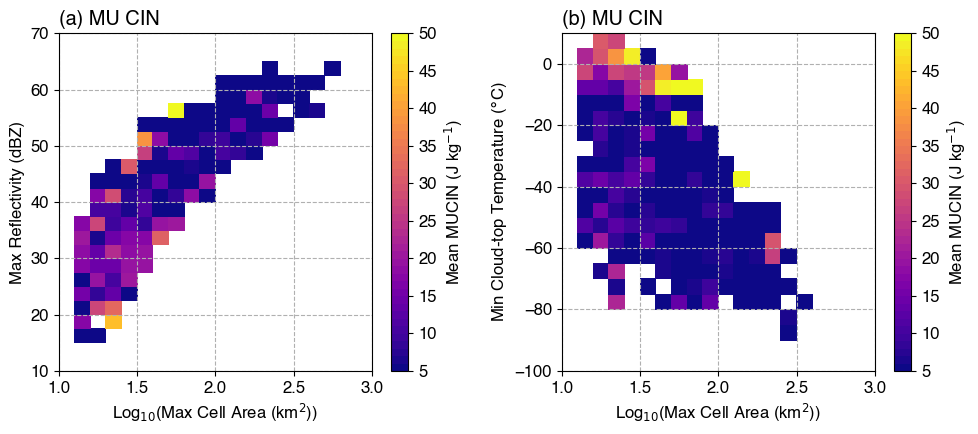

In [53]:
data_arr = [cin_cellareamaxdbz_avg, cin_cellareactt_avg]
xbins = [bin_cellarea, bin_cellarea]
ybins = [bin_maxdbz, bin_ctt]
levels = [np.arange(5,50.1,1), np.arange(5,50.1,1)]
cbticks = [np.arange(5,50.1,5), np.arange(5,50.1,5)]
cmap = 'plasma'
xlabels = ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))']
ylabels = ['Max Reflectivity (dBZ)', 'Min Cloud-top Temperature ($\degree$C)']
titles = ['(a) MU CIN', '(b) MU CIN']
cblabels = ['Mean MUCIN (J kg$^{-1}$)', 'Mean MUCIN (J kg$^{-1}$)']
figname = f'{figdir_jointhist}MUCIN_MaxArea+MinCTT.png'
fig = plot_filledjointhist_2panel(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cblabels, cbticks, figname)

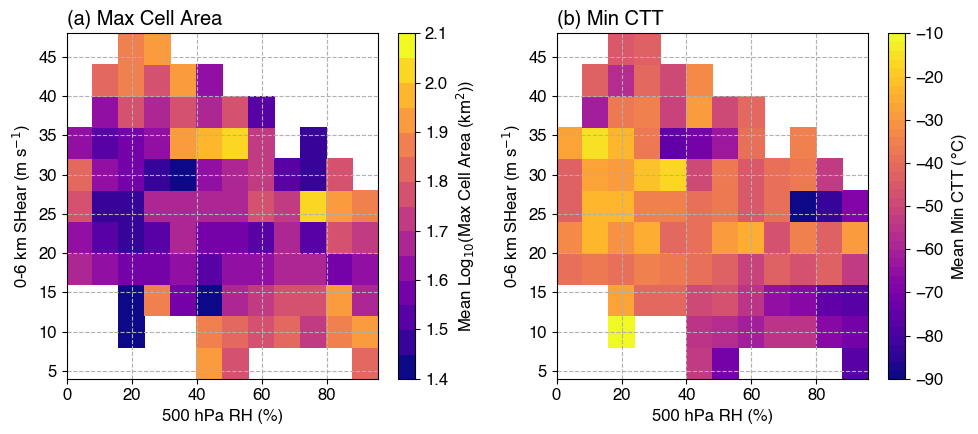

In [54]:
data_arr = [cellarea_rh500shear6mag_avg, ctt_rh500shear6mag_avg]
nsamples_arr = [nsamples_rhshear, nsamples_rhshear]
xbins = [bin_rh, bin_rh]
ybins = [bin_shear6mag, bin_shear6mag]
levels = [np.arange(1.4,2.11,0.05), np.arange(-90,-9.9,2)]
cbticks = [np.arange(1.4,2.11,0.1), np.arange(-90,-9.9,10)]
levels_ct = [10,20,50,100,200]
color_ct = 'limegreen'
cmap = 'plasma'
xlabels = ['500 hPa RH (%)', '500 hPa RH (%)']
ylabels = ['0-6 km SHear (m s$^{-1}$)', '0-6 km SHear (m s$^{-1}$)']
titles = ['(a) Max Cell Area', '(b) Min CTT']
cblabels = ['Mean Log$_{10}$(Max Cell Area (km$^2$))', 'Mean Min CTT ($\degree$C)']
figname = f'{figdir_jointhist}MaxArea_MinCTT_RH500+Shear6km.png'
fig = plot_filledjointhist_2panel(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cblabels, cbticks, figname)
# fig = plot_filledjointhist_2panel(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cblabels, cbticks, figname, 
#                                   nsamples=nsamples_arr, levels_ct=levels_ct, color_ct=color_ct)

In [55]:
figdir_jointhist

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1/figures/celltrack_environment_stats/jointhist/'

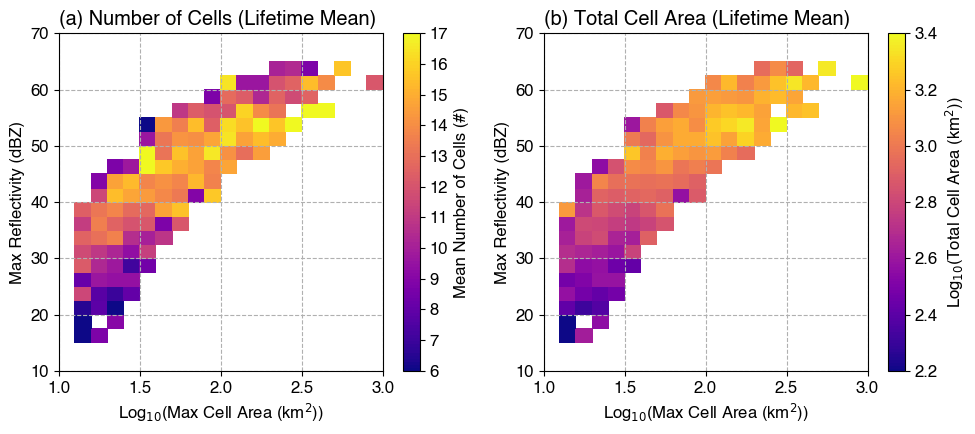

In [56]:
data_arr = [ncells_cellareamaxdbz_avg, np.log10(totalcellarea_cellareamaxdbz_avg)]
xbins = [bin_cellarea, bin_cellarea]
ybins = [bin_maxdbz, bin_maxdbz]
levels = [np.arange(6,17.01,0.1), np.arange(2.2,3.41,0.01)]
cbticks = [np.arange(6,17.01,1), np.arange(2.2,3.41,0.2)]
cmap = 'plasma'
xlabels = ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))']
ylabels = ['Max Reflectivity (dBZ)', 'Max Reflectivity (dBZ)']
titles = ['(a) Number of Cells (Lifetime Mean)', '(b) Total Cell Area (Lifetime Mean)']
cblabels = ['Mean Number of Cells (#)', 'Log$_{10}$(Total Cell Area (km$^2$))']
figname = f'{figdir_jointhist}DomainCellNumberArea_MaxArea+MaxDBZ.png'
# figname = f'{figdir_jointhist}DomainCellNumberArea_MaxArea+MaxDBZ.pdf'
fig = plot_filledjointhist_2panel(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cblabels, cbticks, figname)

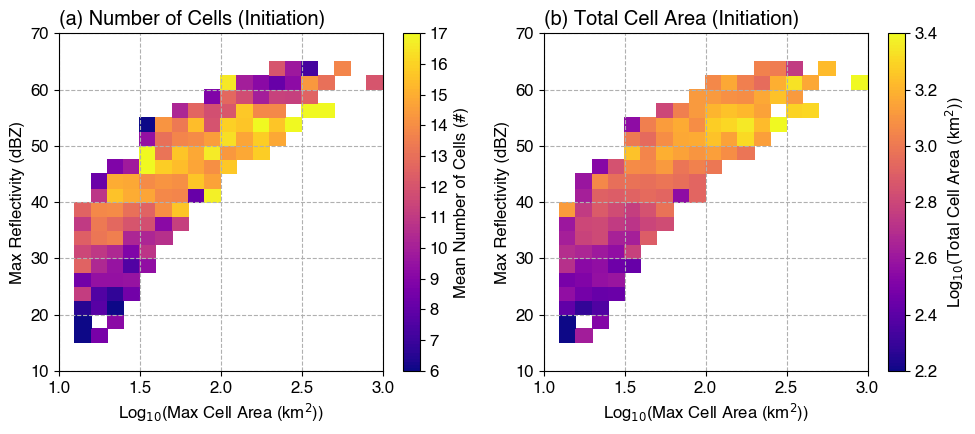

In [57]:
data_arr = [ncellsInit_cellareamaxdbz_avg, np.log10(totalcellareaInit_cellareamaxdbz_avg)]
xbins = [bin_cellarea, bin_cellarea]
ybins = [bin_maxdbz, bin_maxdbz]
levels = [np.arange(6,17.01,0.1), np.arange(2.2,3.41,0.01)]
cbticks = [np.arange(6,17.01,1), np.arange(2.2,3.41,0.2)]
cmap = 'plasma'
xlabels = ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))']
ylabels = ['Max Reflectivity (dBZ)', 'Max Reflectivity (dBZ)']
titles = ['(a) Number of Cells (Initiation)', '(b) Total Cell Area (Initiation)']
cblabels = ['Mean Number of Cells (#)', 'Log$_{10}$(Total Cell Area (km$^2$))']
figname = f'{figdir_jointhist}DomainCellNumberAreaInitiation_MaxArea+MaxDBZ.png'
fig = plot_filledjointhist_2panel(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cblabels, cbticks, figname)

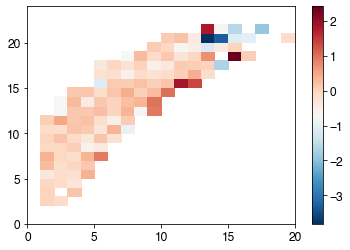

In [58]:
ncell_diff = (ncellsInit_cellareamaxdbz_avg - ncells_cellareamaxdbz_avg)
plt.pcolormesh(ncell_diff, cmap='RdBu_r')
plt.colorbar()

In [59]:
def plot_filledjointhist_2x3(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cbticks, cblabels, figname):

    mpl.rcParams['font.size'] = 10
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['figure.facecolor'] = 'white'
    fig, axes = plt.subplots(2, 3, figsize=(12, 7), dpi=100)

    for row in range(2):
        for col in range(3):
            ax = axes[row, col]
            Zm = np.ma.masked_invalid(data_arr[row][col])
            # Normalize colormap
            cmap = plt.get_cmap(cmap)
            norm = mpl.colors.BoundaryNorm(levels[row][col], ncolors=cmap.N)
            pcm = ax.pcolormesh(xbins[row][col], ybins[row][col], Zm, norm=norm, cmap=cmap)
            cb = plt.colorbar(pcm, ax=ax, label=cblabels[row][col], ticks=cbticks[row][col])
            ax.grid(ls='--')
            ax.set_xlabel(xlabels[row][col])
            ax.set_ylabel(ylabels[row][col])
            ax.set_title(titles[row][col], loc='left')
    
    fig.tight_layout()
    fig.savefig(figname, bbox_inches='tight', dpi=300)
    
    return fig

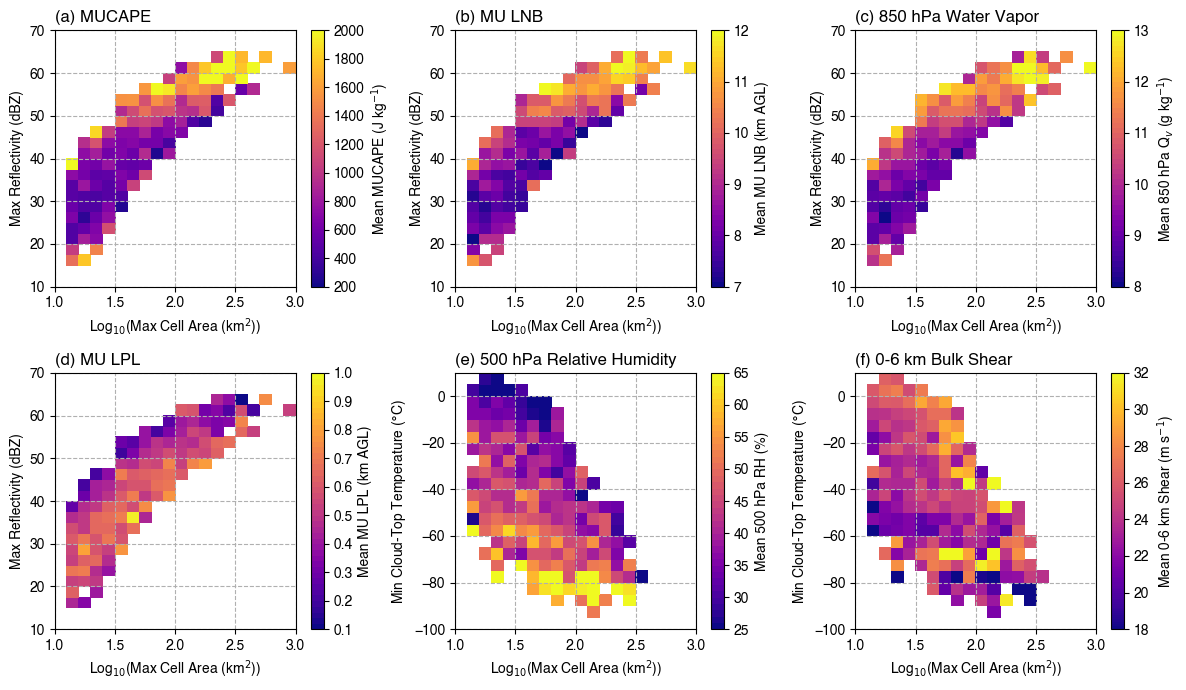

In [60]:
data_arr = [[cape_cellareamaxdbz_avg, lnb_z_cellareamaxdbz_avg, q850p_cellareamaxdbz_avg], 
            [lpl_z_cellareamaxdbz_avg, rh500p_cellareactt_avg, shear6mag_cellareactt_avg]]
xbins = [[bin_cellarea, bin_cellarea, bin_cellarea],[bin_cellarea, bin_cellarea, bin_cellarea]]
ybins = [[bin_maxdbz, bin_maxdbz, bin_maxdbz], [bin_maxdbz, bin_ctt, bin_ctt]]
levels = [[np.arange(200,2001,10), np.arange(7,12.01,0.1), np.arange(8, 13.01, 0.1)], 
          [np.arange(0.1, 1.01, 0.02), np.arange(25, 65.1, 1), np.arange(18, 32.01, 0.1)]]
cbticks = [[np.arange(200,2001,200), np.arange(7,12.01,1), np.arange(8, 13.01, 1)], 
           [np.arange(0.1, 1.01, 0.1), np.arange(25, 65.1, 5), np.arange(18, 32.01, 2)]]
cmap = 'plasma'
xlabels = [['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))'], 
           ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))']]
ylabels = [['Max Reflectivity (dBZ)', 'Max Reflectivity (dBZ)', 'Max Reflectivity (dBZ)'], 
           ['Max Reflectivity (dBZ)', 'Min Cloud-Top Temperature ($\degree$C)', 'Min Cloud-Top Temperature ($\degree$C)']]
titles = [['(a) MUCAPE', '(b) MU LNB', '(c) 850 hPa Water Vapor'], 
          ['(d) MU LPL', '(e) 500 hPa Relative Humidity', '(f) 0-6 km Bulk Shear']]
cblabels = [['Mean MUCAPE (J kg$^{-1}$)', 'Mean MU LNB (km AGL)', 'Mean 850 hPa Q$_v$ (g kg$^{-1}$)'], 
            ['Mean MU LPL (km AGL)', 'Mean 500 hPa RH (%)', 'Mean 0-6 km Shear (m s$^{-1}$)']]
# figname = f'{figdir_jointhist}Parcel_Humidity_Shear_Stats_MaxArea+MaxDBZ+MinCTT.png'
figname = f'{figdir_jointhist}Parcel_Humidity_Shear_Stats_MaxArea+MaxDBZ+MinCTT.pdf'
fig = plot_filledjointhist_2x3(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cbticks, cblabels, figname)

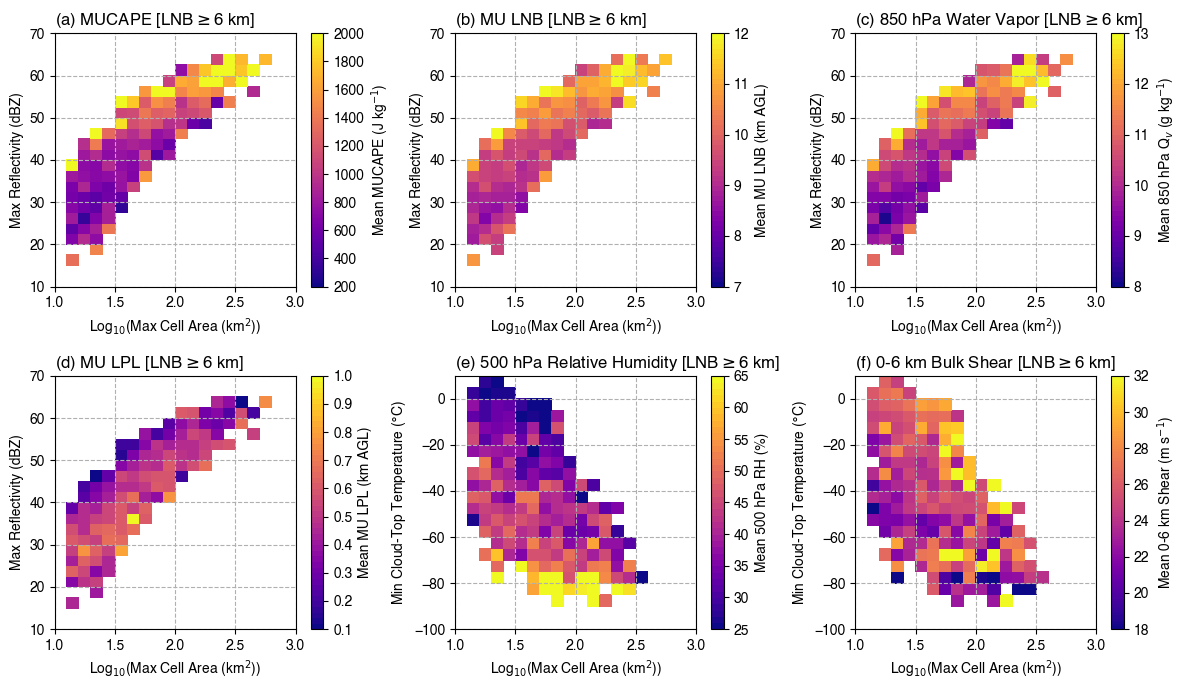

In [61]:
data_arr = [[capeLNB6km_cellareamaxdbz_avg, lnb_zLNB6km_cellareamaxdbz_avg, q850pLNB6km_cellareamaxdbz_avg], 
            [lpl_zLNB6km_cellareamaxdbz_avg, rh500pLNB6km_cellareactt_avg, shear6magLNB6km_cellareactt_avg]]
xbins = [[bin_cellarea, bin_cellarea, bin_cellarea],[bin_cellarea, bin_cellarea, bin_cellarea]]
ybins = [[bin_maxdbz, bin_maxdbz, bin_maxdbz], [bin_maxdbz, bin_ctt, bin_ctt]]
levels = [[np.arange(200,2001,10), np.arange(7,12.01,0.1), np.arange(8, 13.01, 0.1)], 
          [np.arange(0.1, 1.01, 0.02), np.arange(25, 65.1, 1), np.arange(18, 32.01, 0.1)]]
cbticks = [[np.arange(200,2001,200), np.arange(7,12.01,1), np.arange(8, 13.01, 1)], 
           [np.arange(0.1, 1.01, 0.1), np.arange(25, 65.1, 5), np.arange(18, 32.01, 2)]]
cmap = 'plasma'
xlabels = [['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))'], 
           ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))']]
ylabels = [['Max Reflectivity (dBZ)', 'Max Reflectivity (dBZ)', 'Max Reflectivity (dBZ)'], 
           ['Max Reflectivity (dBZ)', 'Min Cloud-Top Temperature ($\degree$C)', 'Min Cloud-Top Temperature ($\degree$C)']]
titles = [['(a) MUCAPE [LNB$\geq$6 km]', '(b) MU LNB [LNB$\geq$6 km]', '(c) 850 hPa Water Vapor [LNB$\geq$6 km]'], 
          ['(d) MU LPL [LNB$\geq$6 km]', '(e) 500 hPa Relative Humidity [LNB$\geq$6 km]', '(f) 0-6 km Bulk Shear [LNB$\geq$6 km]']]
cblabels = [['Mean MUCAPE (J kg$^{-1}$)', 'Mean MU LNB (km AGL)', 'Mean 850 hPa Q$_v$ (g kg$^{-1}$)'], 
            ['Mean MU LPL (km AGL)', 'Mean 500 hPa RH (%)', 'Mean 0-6 km Shear (m s$^{-1}$)']]
figname = f'{figdir_jointhist}Parcel_Humidity_Shear_Stats_LNB6km_MaxArea+MaxDBZ+MinCTT.png'
fig = plot_filledjointhist_2x3(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cbticks, cblabels, figname)

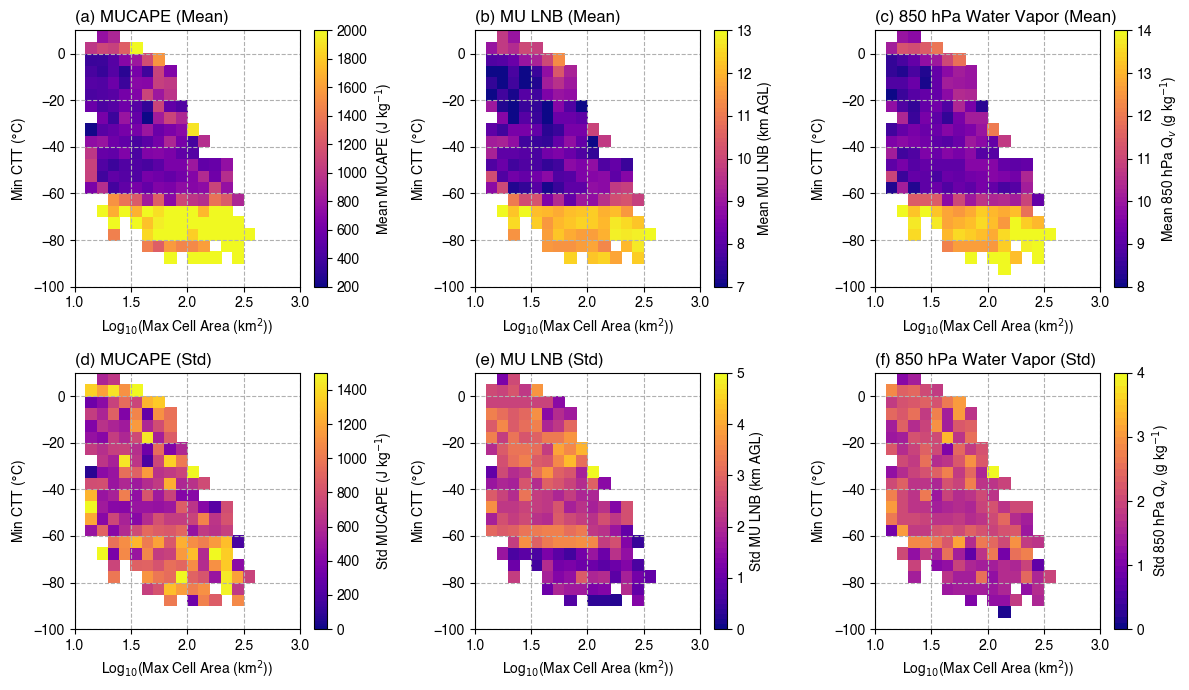

In [62]:
data_arr = [[cape_cellareactt_avg, lnb_z_cellareactt_avg, q850p_cellareactt_avg], 
            [cape_cellareactt_std, lnb_z_cellareactt_std, q850p_cellareactt_std]]
xbins = [[bin_cellarea, bin_cellarea, bin_cellarea],[bin_cellarea, bin_cellarea, bin_cellarea]]
ybins = [[bin_ctt, bin_ctt, bin_ctt], [bin_ctt, bin_ctt, bin_ctt]]
levels = [[np.arange(200, 2001, 10), np.arange(7, 13.01, 0.1), np.arange(8, 14.01, 0.1)], 
          [np.arange(0, 1500.1, 10), np.arange(0, 5.01, 0.1), np.arange(0, 4.01, 0.1)]]
cbticks = [[np.arange(200, 2001, 200), np.arange(7, 13.01, 1), np.arange(8, 14.01, 1)], 
          [np.arange(0, 1600.1, 200), np.arange(0, 5.01, 1), np.arange(0, 4.01, 1)]]
cmap = 'plasma'
xlabels = [['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))'], 
           ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))']]
ylabels = [['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)', 'Min CTT ($\degree$C)'], 
           ['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)', 'Min CTT ($\degree$C)']]
titles = [['(a) MUCAPE (Mean)', '(b) MU LNB (Mean)', '(c) 850 hPa Water Vapor (Mean)'], ['(d) MUCAPE (Std)', '(e) MU LNB (Std)', '(f) 850 hPa Water Vapor (Std)']]
cblabels = [['Mean MUCAPE (J kg$^{-1}$)', 'Mean MU LNB (km AGL)', 'Mean 850 hPa Q$_v$ (g kg$^{-1}$)'], 
            ['Std MUCAPE (J kg$^{-1}$)', 'Std MU LNB (km AGL)', 'Std 850 hPa Q$_v$ (g kg$^{-1}$)']]
figname = f'{figdir_jointhist}ParcelStats_MaxArea+MinCTT_MeanStd.png'
fig = plot_filledjointhist_2x3(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cbticks, cblabels, figname)

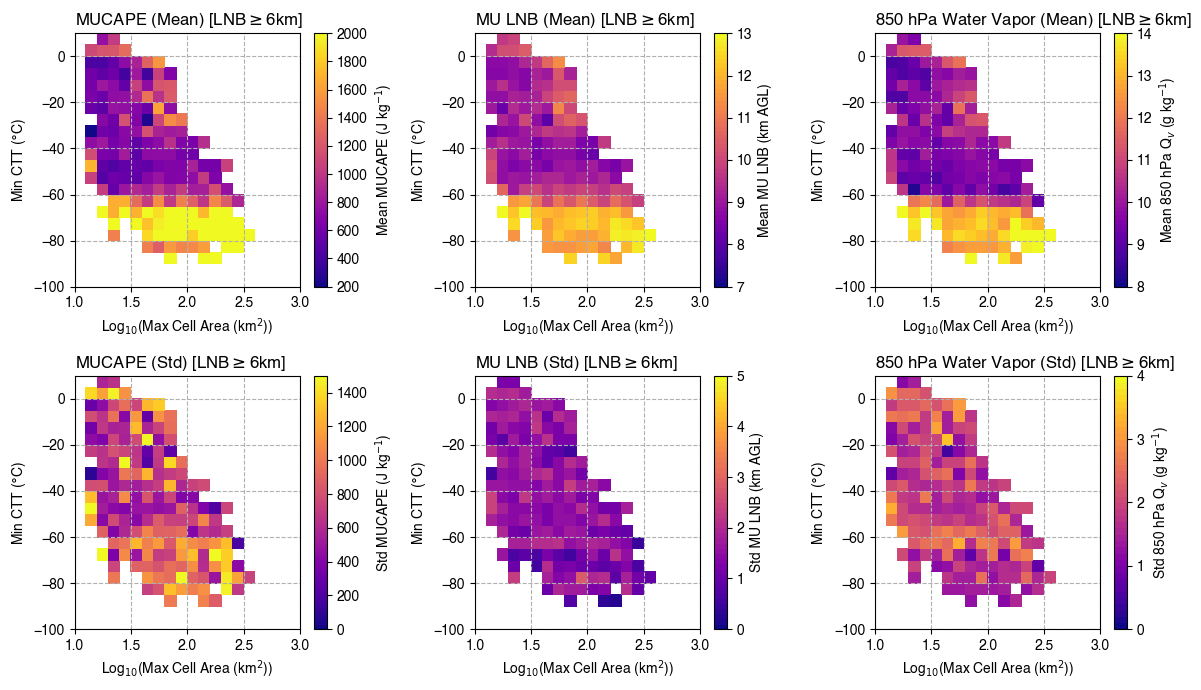

In [63]:
data_arr = [[capeLNB6km_cellareactt_avg, lnb_zLNB6km_cellareactt_avg, q850pLNB6km_cellareactt_avg], 
            [capeLNB6km_cellareactt_std, lnb_zLNB6km_cellareactt_std, q850pLNB6km_cellareactt_std]]
xbins = [[bin_cellarea, bin_cellarea, bin_cellarea],[bin_cellarea, bin_cellarea, bin_cellarea]]
ybins = [[bin_ctt, bin_ctt, bin_ctt], [bin_ctt, bin_ctt, bin_ctt]]
levels = [[np.arange(200, 2001, 10), np.arange(7, 13.01, 0.1), np.arange(8, 14.01, 0.1)], 
          [np.arange(0, 1500.1, 10), np.arange(0, 5.01, 0.1), np.arange(0, 4.01, 0.1)]]
cbticks = [[np.arange(200, 2001, 200), np.arange(7, 13.01, 1), np.arange(8, 14.01, 1)], 
          [np.arange(0, 1600.1, 200), np.arange(0, 5.01, 1), np.arange(0, 4.01, 1)]]
cmap = 'plasma'
xlabels = [['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))'], 
           ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))']]
ylabels = [['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)', 'Min CTT ($\degree$C)'], 
           ['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)', 'Min CTT ($\degree$C)']]
titles = [['MUCAPE (Mean) [LNB$\geq$6km]', 'MU LNB (Mean) [LNB$\geq$6km]', '850 hPa Water Vapor (Mean) [LNB$\geq$6km]'], 
          ['MUCAPE (Std) [LNB$\geq$6km]', 'MU LNB (Std) [LNB$\geq$6km]', '850 hPa Water Vapor (Std) [LNB$\geq$6km]']]
cblabels = [['Mean MUCAPE (J kg$^{-1}$)', 'Mean MU LNB (km AGL)', 'Mean 850 hPa Q$_v$ (g kg$^{-1}$)'], 
            ['Std MUCAPE (J kg$^{-1}$)', 'Std MU LNB (km AGL)', 'Std 850 hPa Q$_v$ (g kg$^{-1}$)']]
figname = f'{figdir_jointhist}ParcelStats_LNB6km_MaxArea+MinCTT_MeanStd.png'
fig = plot_filledjointhist_2x3(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cbticks, cblabels, figname)

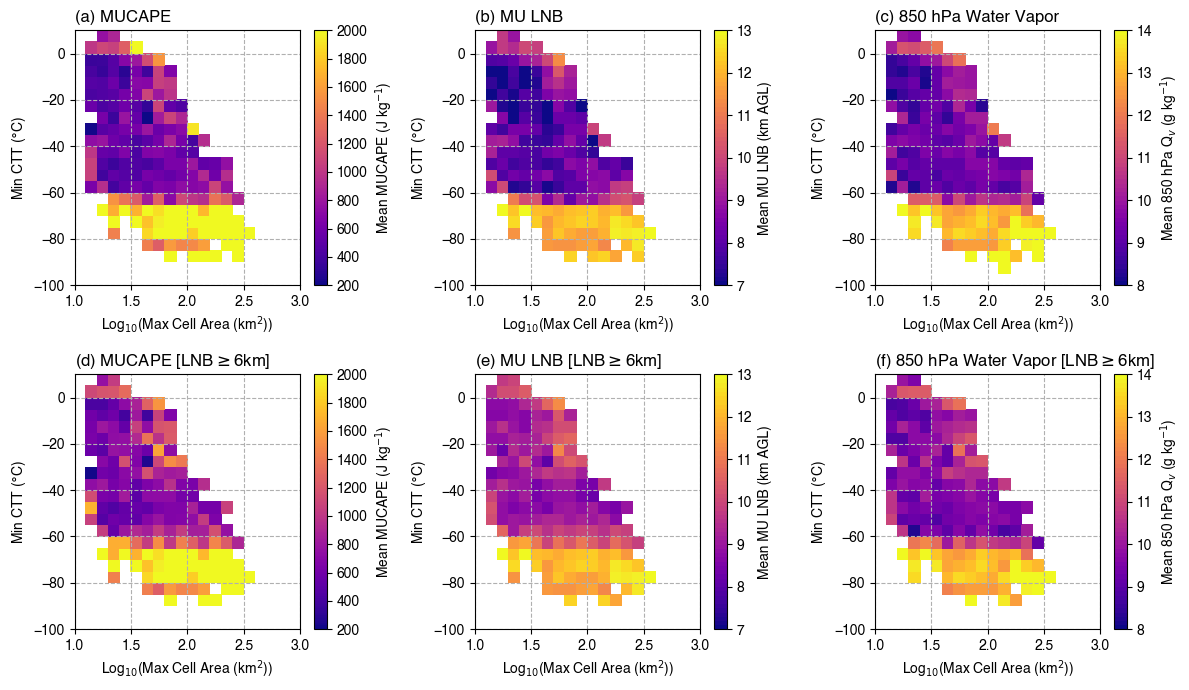

In [64]:
data_arr = [[cape_cellareactt_avg, lnb_z_cellareactt_avg, q850p_cellareactt_avg], 
            [capeLNB6km_cellareactt_avg, lnb_zLNB6km_cellareactt_avg, q850pLNB6km_cellareactt_avg]]
xbins = [[bin_cellarea, bin_cellarea, bin_cellarea], [bin_cellarea, bin_cellarea, bin_cellarea]]
ybins = [[bin_ctt, bin_ctt, bin_ctt], [bin_ctt, bin_ctt, bin_ctt]]
levels = [[np.arange(200, 2001, 10), np.arange(7, 13.01, 0.1), np.arange(8, 14.01, 0.1)], 
          [np.arange(200, 2001, 10), np.arange(7, 13.01, 0.1), np.arange(8, 14.01, 0.1)]]
cbticks = [[np.arange(200, 2001, 200), np.arange(7, 13.01, 1), np.arange(8, 14.01, 1)], 
          [np.arange(200, 2001, 200), np.arange(7, 13.01, 1), np.arange(8, 14.01, 1)]]
cmap = 'plasma'
xlabels = [['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))'], 
           ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))']]
ylabels = [['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)', 'Min CTT ($\degree$C)'], 
           ['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)', 'Min CTT ($\degree$C)']]
titles = [['(a) MUCAPE', '(b) MU LNB', '(c) 850 hPa Water Vapor'], 
          ['(d) MUCAPE [LNB$\geq$6km]', '(e) MU LNB [LNB$\geq$6km]', '(f) 850 hPa Water Vapor [LNB$\geq$6km]']]
cblabels = [['Mean MUCAPE (J kg$^{-1}$)', 'Mean MU LNB (km AGL)', 'Mean 850 hPa Q$_v$ (g kg$^{-1}$)'], 
            ['Mean MUCAPE (J kg$^{-1}$)', 'Mean MU LNB (km AGL)', 'Mean 850 hPa Q$_v$ (g kg$^{-1}$)']]
figname = f'{figdir_jointhist}ParcelStats_LNB6km_MaxArea+MinCTT_Mean.png'
fig = plot_filledjointhist_2x3(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cbticks, cblabels, figname)

In [65]:
figdir_jointhist

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1/figures/celltrack_environment_stats/jointhist/'

In [66]:
def plot_filledjointhist_2x2(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cblabels, figname, cbticks=None):

    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['figure.facecolor'] = 'white'
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=100)

    for row in range(2):
        for col in range(2):
            ax = axes[row, col]
            Zm = np.ma.masked_where(data_arr[row][col] <= 0, data_arr[row][col])
            # Normalize colormap
            cmap = plt.get_cmap(cmap)
            norm = mpl.colors.BoundaryNorm(levels[row][col], ncolors=cmap.N)
            pcm = ax.pcolormesh(xbins[row][col], ybins[row][col], Zm, norm=norm, cmap=cmap)
#             cnt = ax.contour(xbins[row][col][:-1], ybins[row][col][:-1], nsample_arr, levels=levels_ct, colors='g')
            cb = plt.colorbar(pcm, ax=ax, label=cblabels[row][col])
            if cbticks is not None:
                cb.set_ticks(cbticks[row][col])
            ax.grid(ls='--')
            ax.set_xlabel(xlabels[row][col])
            ax.set_ylabel(ylabels[row][col])
            ax.set_title(titles[row][col], loc='left')
    
    fig.tight_layout()
    fig.savefig(figname, bbox_inches='tight', dpi=300)
    
    return fig

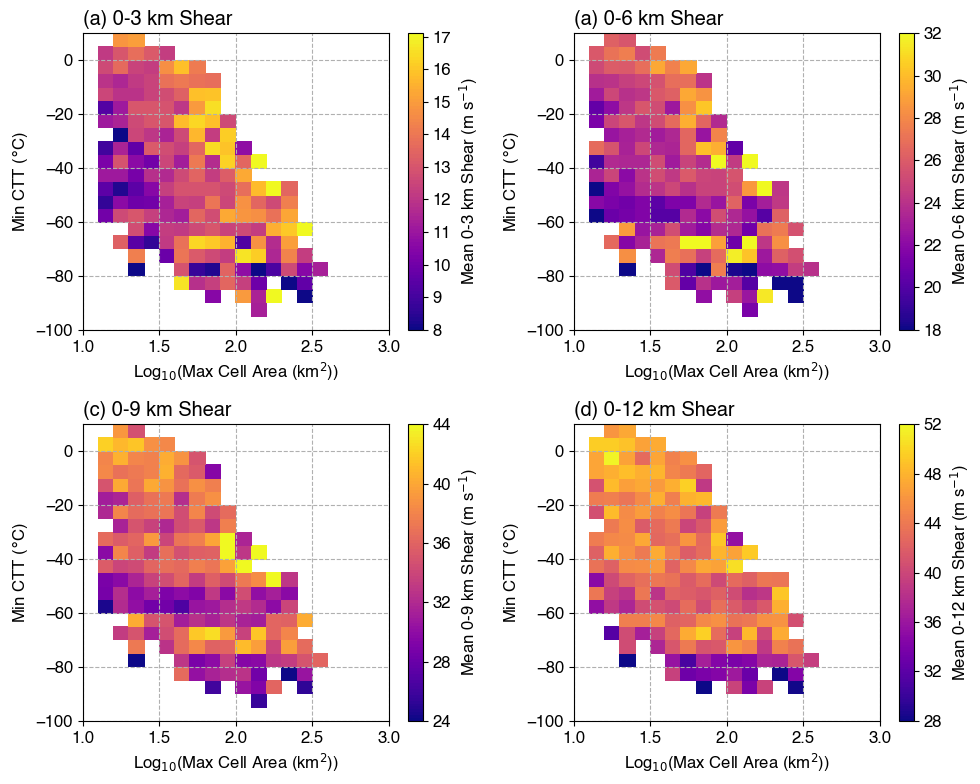

In [67]:
data_arr = [[shear3mag_cellareactt_avg, shear6mag_cellareactt_avg], 
            [shear9mag_cellareactt_avg, shear12mag_cellareactt_avg]]
xbins = [[bin_cellarea, bin_cellarea],[bin_cellarea, bin_cellarea]]
ybins = [[bin_ctt, bin_ctt], [bin_ctt, bin_ctt]]
levels = [[np.arange(8,17.1,0.1), np.arange(18,32.1,0.1)], 
          [np.arange(24,44.1,0.2), np.arange(28, 52.01, 0.2)]]
cbticks = [[np.arange(8,17.1,1), np.arange(18,32.1,2)], 
           [np.arange(24,44.1,4), np.arange(28, 52.01, 4)]]
cmap = 'plasma'
xlabels = [['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))'], 
           ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))']]
ylabels = [['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)'],
           ['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)']]
titles = [['(a) 0-3 km Shear', '(a) 0-6 km Shear'], ['(c) 0-9 km Shear', '(d) 0-12 km Shear']]
cblabels = [['Mean 0-3 km Shear (m s$^{-1}$)', 'Mean 0-6 km Shear (m s$^{-1}$)'],
            ['Mean 0-9 km Shear (m s$^{-1}$)', 'Mean 0-12 km Shear (m s$^{-1}$)']]
figname = f'{figdir_jointhist}ShearStats_MaxArea+MinCTT.png'
fig = plot_filledjointhist_2x2(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cblabels, figname, cbticks=cbticks)

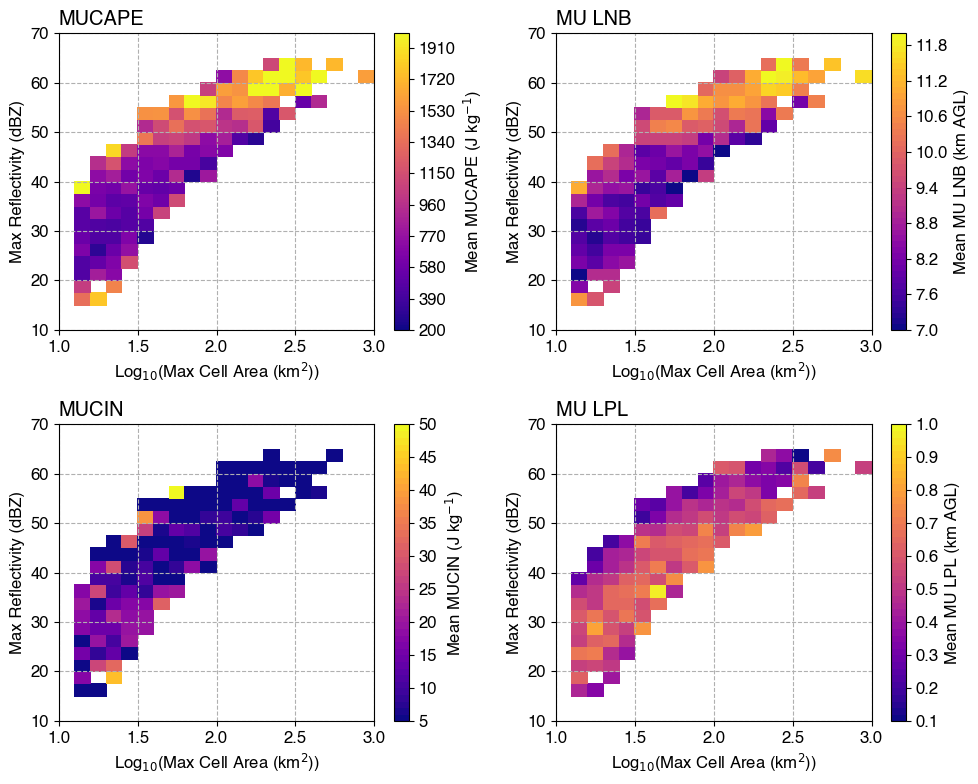

In [68]:
data_arr = [[cape_cellareamaxdbz_avg, lnb_z_cellareamaxdbz_avg], 
            [cin_cellareamaxdbz_avg, lpl_z_cellareamaxdbz_avg]]
xbins = [[bin_cellarea, bin_cellarea],[bin_cellarea, bin_cellarea]]
ybins = [[bin_maxdbz, bin_maxdbz], [bin_maxdbz, bin_maxdbz]]
# levels = [[np.arange(200,1701,10), np.arange(8,12.1,0.1)], 
#           [np.arange(5,50.1,1), np.arange(1.5, 3.01, 0.05)]]
levels = [[np.arange(200,2001,10), np.arange(7,12.01,0.1)], 
          [np.arange(5,50.1,1), np.arange(0.1, 1.01, 0.02)]]
cmap = 'plasma'
xlabels = [['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))'], 
           ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))']]
ylabels = [['Max Reflectivity (dBZ)', 'Max Reflectivity (dBZ)'], 
           ['Max Reflectivity (dBZ)', 'Max Reflectivity (dBZ)']]
titles = [['MUCAPE', 'MU LNB'], ['MUCIN', 'MU LPL']]
cblabels = [['Mean MUCAPE (J kg$^{-1}$)', 'Mean MU LNB (km AGL)'], 
            ['Mean MUCIN (J kg$^{-1}$)', 'Mean MU LPL (km AGL)']]
figname = f'{figdir_jointhist}ParcelStats_MaxArea+MaxDBZ.png'
fig = plot_filledjointhist_2x2(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cblabels, figname)

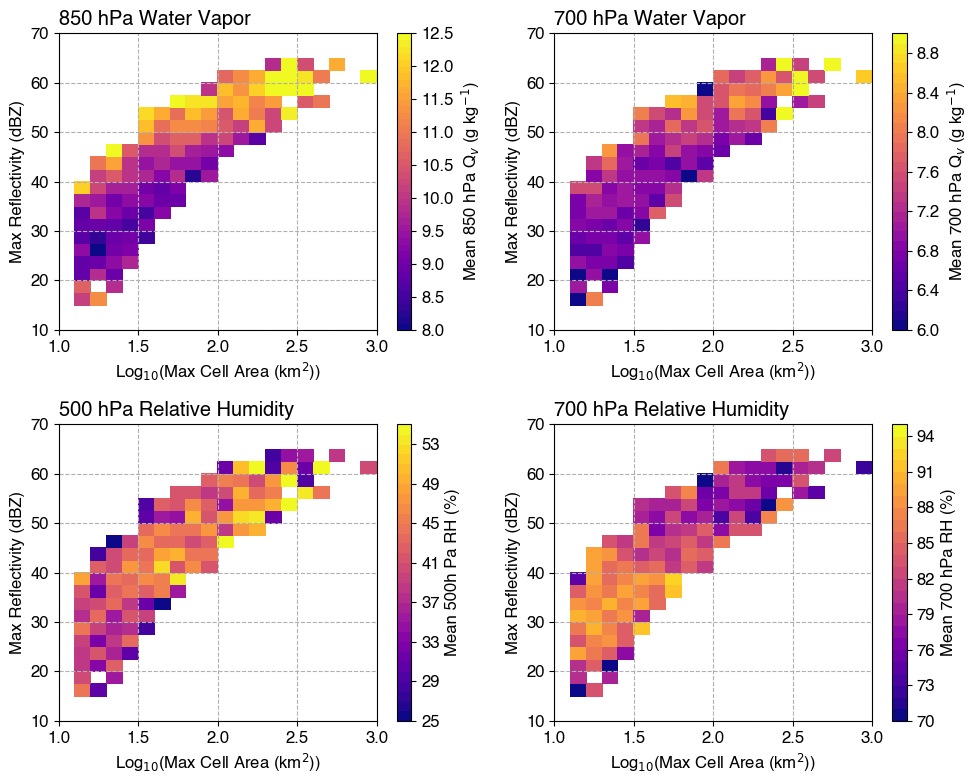

In [69]:
data_arr = [[q850p_cellareamaxdbz_avg, q700p_cellareamaxdbz_avg], 
            [rh500p_cellareamaxdbz_avg, rh700p_cellareamaxdbz_avg]]
xbins = [[bin_cellarea, bin_cellarea],[bin_cellarea, bin_cellarea]]
ybins = [[bin_maxdbz, bin_maxdbz], [bin_maxdbz, bin_maxdbz]]
levels = [[np.arange(8, 12.51, 0.1), np.arange(6, 9.01, 0.1)], 
          [np.arange(25, 55.1, 1), np.arange(70, 95.01, 1)]]
cmap = 'plasma'
xlabels = [['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))'], 
           ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))']]
ylabels = [['Max Reflectivity (dBZ)', 'Max Reflectivity (dBZ)'], 
           ['Max Reflectivity (dBZ)', 'Max Reflectivity (dBZ)']]
titles = [['850 hPa Water Vapor', '700 hPa Water Vapor'], ['500 hPa Relative Humidity', '700 hPa Relative Humidity']]
cblabels = [['Mean 850 hPa Q$_v$ (g kg$^{-1}$)', 'Mean 700 hPa Q$_v$ (g kg$^{-1}$)'], 
            ['Mean 500h Pa RH (%)', 'Mean 700 hPa RH (%)']]
figname = f'{figdir_jointhist}HumidityStats_MaxArea+MaxDBZ.png'
fig = plot_filledjointhist_2x2(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cblabels, figname)

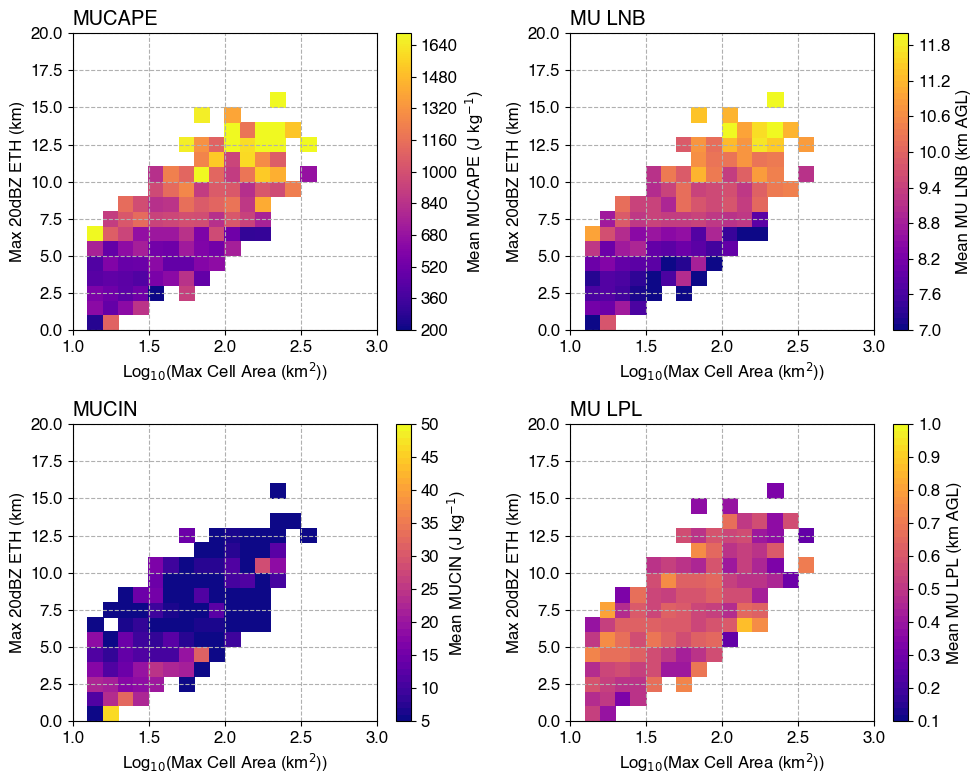

In [70]:
data_arr = [[cape_cellareaeth20_avg, lnb_z_cellareaeth20_avg], 
            [cin_cellareaeth20_avg, lpl_z_cellareaeth20_avg]]
xbins = [[bin_cellarea, bin_cellarea],[bin_cellarea, bin_cellarea]]
ybins = [[bin_eth, bin_eth], [bin_eth, bin_eth]]
# levels = [[np.arange(200,1701,10), np.arange(8,12.1,0.1)], 
#           [np.arange(5,50.1,1), np.arange(1.5, 3.01, 0.05)]]
levels = [[np.arange(200,1701,10), np.arange(7,12.01,0.1)], 
          [np.arange(5,50.1,1), np.arange(0.1, 1.01, 0.02)]]
cmap = 'plasma'
xlabels = [['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))'], 
           ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))']]
ylabels = [['Max 20dBZ ETH (km)', 'Max 20dBZ ETH (km)'], 
           ['Max 20dBZ ETH (km)', 'Max 20dBZ ETH (km)']]
titles = [['MUCAPE', 'MU LNB'], ['MUCIN', 'MU LPL']]
cblabels = [['Mean MUCAPE (J kg$^{-1}$)', 'Mean MU LNB (km AGL)'], 
            ['Mean MUCIN (J kg$^{-1}$)', 'Mean MU LPL (km AGL)']]
figname = f'{figdir_jointhist}ParcelStats_MaxArea+MaxETH20.png'
fig = plot_filledjointhist_2x2(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cblabels, figname)

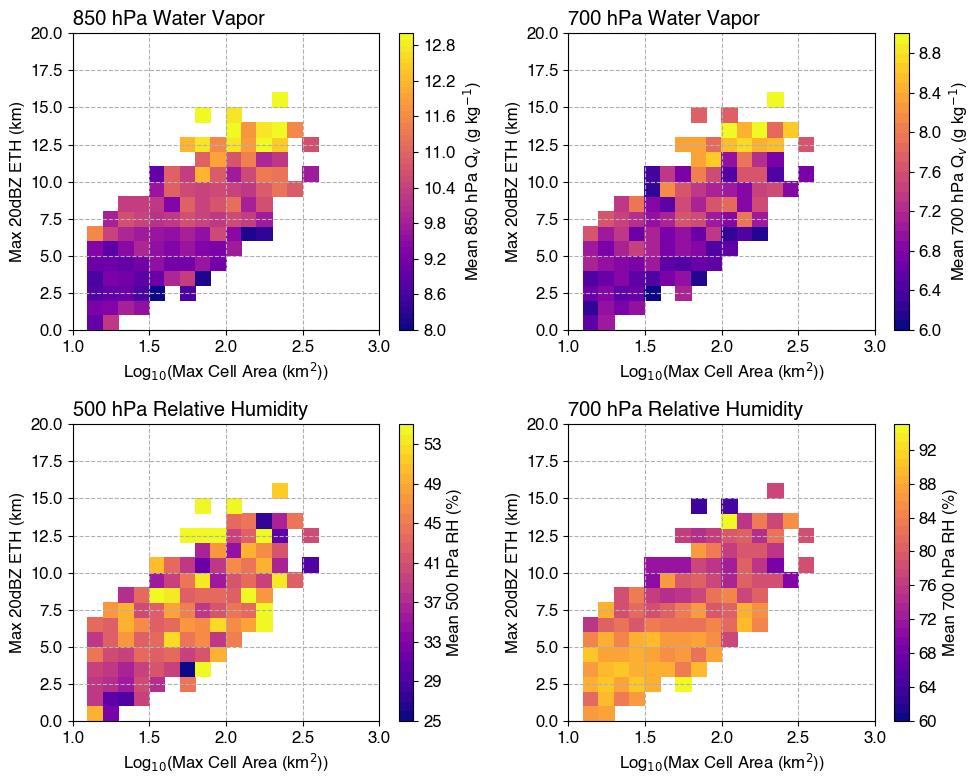

In [71]:
data_arr = [[q850p_cellareaeth20_avg, q700p_cellareaeth20_avg], 
            [rh500p_cellareaeth20_avg, rh700p_cellareaeth20_avg]]
xbins = [[bin_cellarea, bin_cellarea],[bin_cellarea, bin_cellarea]]
ybins = [[bin_eth, bin_eth], [bin_eth, bin_eth]]
levels = [[np.arange(8, 13.01, 0.1), np.arange(6, 9.01, 0.1)], 
          [np.arange(25, 55.1, 1), np.arange(60, 95.01, 1)]]
cmap = 'plasma'
xlabels = [['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))'], 
           ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))']]
ylabels = [['Max 20dBZ ETH (km)', 'Max 20dBZ ETH (km)'], 
           ['Max 20dBZ ETH (km)', 'Max 20dBZ ETH (km)']]
titles = [['850 hPa Water Vapor', '700 hPa Water Vapor'], ['500 hPa Relative Humidity', '700 hPa Relative Humidity']]
cblabels = [['Mean 850 hPa Q$_v$ (g kg$^{-1}$)', 'Mean 700 hPa Q$_v$ (g kg$^{-1}$)'], 
            ['Mean 500 hPa RH (%)', 'Mean 700 hPa RH (%)']]
figname = f'{figdir_jointhist}HumidityStats_MaxArea+MaxETH20.png'
fig = plot_filledjointhist_2x2(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cblabels, figname)

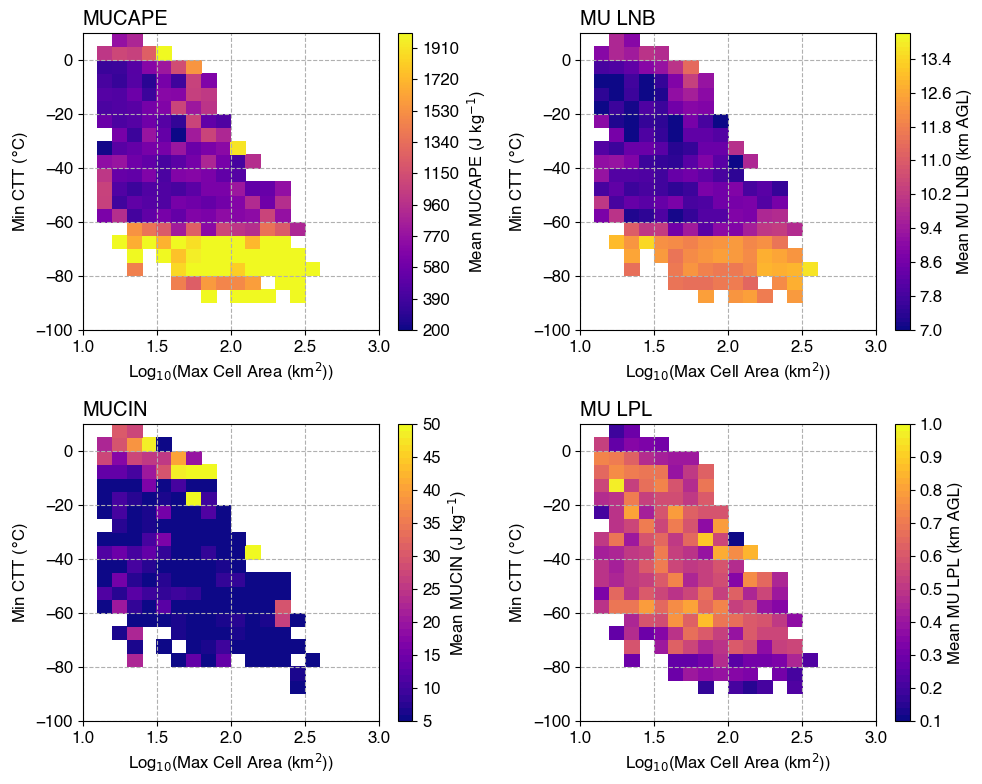

In [72]:
data_arr = [[cape_cellareactt_avg, lnb_z_cellareactt_avg], 
            [cin_cellareactt_avg, lpl_z_cellareactt_avg]]
xbins = [[bin_cellarea, bin_cellarea],[bin_cellarea, bin_cellarea]]
ybins = [[bin_ctt, bin_ctt], [bin_ctt, bin_ctt]]
# levels = [[np.arange(200,2001,10), np.arange(8,14.1,0.1)], 
#           [np.arange(5,50.1,1), np.arange(1.5, 3.01, 0.05)]]
levels = [[np.arange(200,2001,10), np.arange(7, 14.1,0.1)], 
          [np.arange(5,50.1,1), np.arange(0.1, 1.01, 0.02)]]
cmap = 'plasma'
xlabels = [['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))'], 
           ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))']]
ylabels = [['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)'], 
           ['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)']]
titles = [['MUCAPE', 'MU LNB'], ['MUCIN', 'MU LPL']]
cblabels = [['Mean MUCAPE (J kg$^{-1}$)', 'Mean MU LNB (km AGL)'], 
            ['Mean MUCIN (J kg$^{-1}$)', 'Mean MU LPL (km AGL)']]
figname = f'{figdir_jointhist}ParcelStats_MaxArea+MinCTT.png'
fig = plot_filledjointhist_2x2(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cblabels, figname)

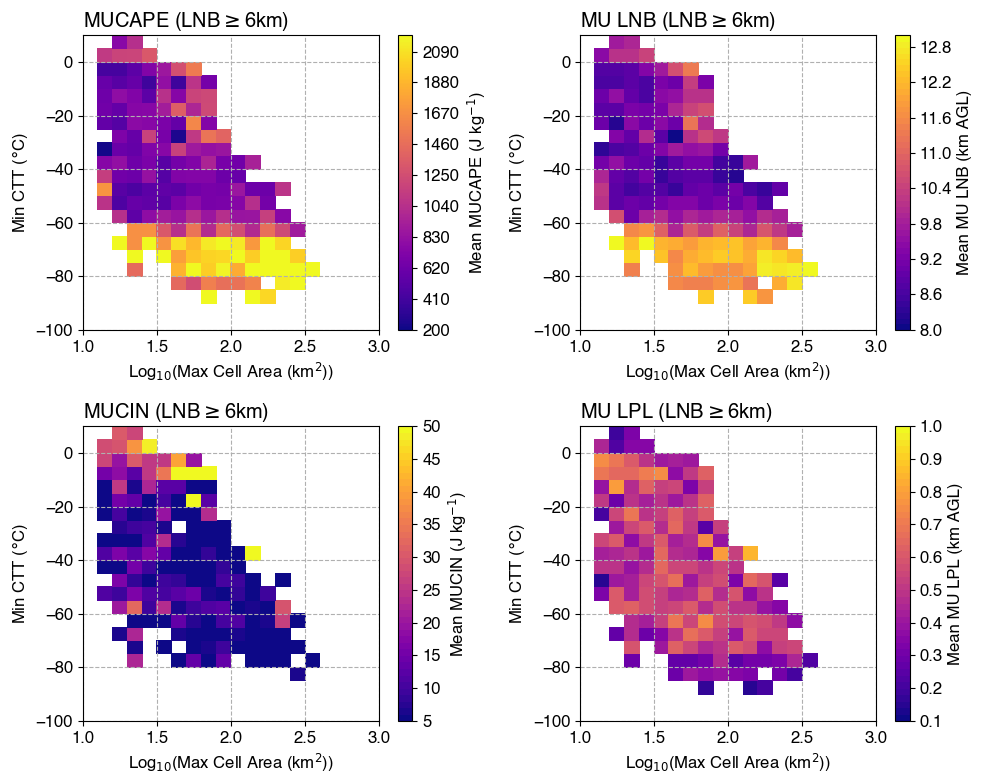

In [73]:
data_arr = [[capeLNB6km_cellareactt_avg, lnb_zLNB6km_cellareactt_avg], 
            [cinLNB6km_cellareactt_avg, lpl_zLNB6km_cellareactt_avg]]
xbins = [[bin_cellarea, bin_cellarea],[bin_cellarea, bin_cellarea]]
ybins = [[bin_ctt, bin_ctt], [bin_ctt, bin_ctt]]
levels = [[np.arange(200,2201,10), np.arange(8, 13.1,0.1)], 
          [np.arange(5,50.1,1), np.arange(0.1, 1.01, 0.02)]]
cmap = 'plasma'
xlabels = [['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))'], 
           ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))']]
ylabels = [['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)'], 
           ['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)']]
titles = [[r'MUCAPE (LNB$\geq$6km)', r'MU LNB (LNB$\geq$6km)'], 
          [r'MUCIN (LNB$\geq$6km)', r'MU LPL (LNB$\geq$6km)']]
cblabels = [['Mean MUCAPE (J kg$^{-1}$)', 'Mean MU LNB (km AGL)'], 
            ['Mean MUCIN (J kg$^{-1}$)', 'Mean MU LPL (km AGL)']]
figname = f'{figdir_jointhist}ParcelStats_LNB6km_MaxArea+MinCTT.png'
fig = plot_filledjointhist_2x2(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cblabels, figname)

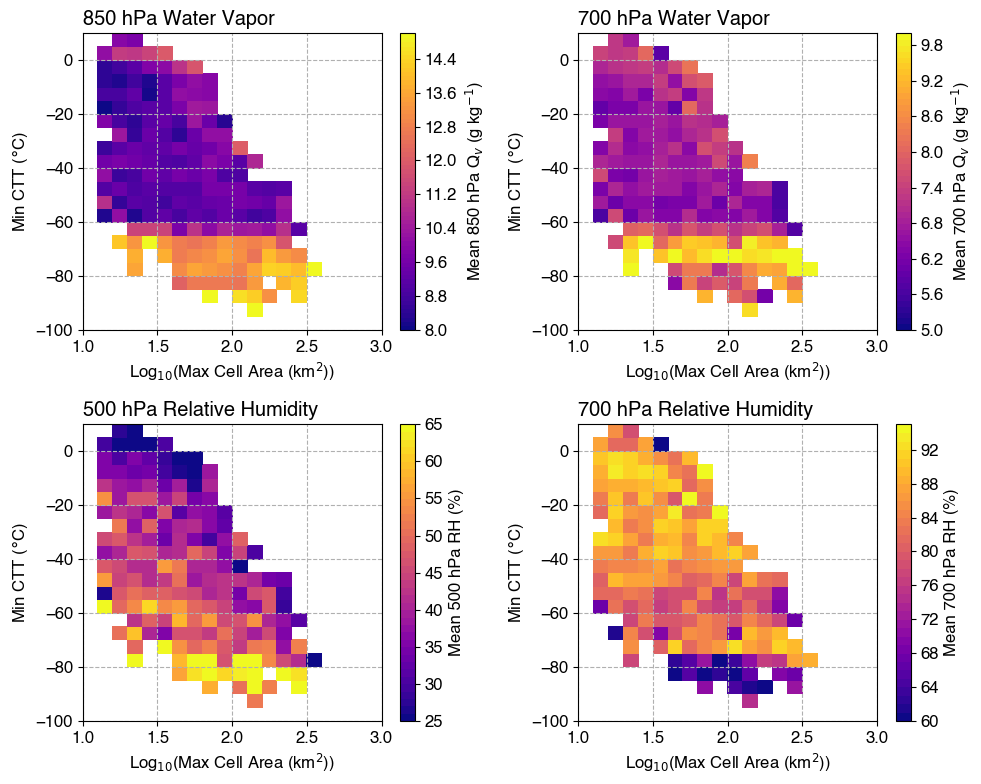

In [74]:
data_arr = [[q850p_cellareactt_avg, q700p_cellareactt_avg], 
            [rh500p_cellareactt_avg, rh700p_cellareactt_avg]]
xbins = [[bin_cellarea, bin_cellarea],[bin_cellarea, bin_cellarea]]
ybins = [[bin_ctt, bin_ctt], [bin_ctt, bin_ctt]]
levels = [[np.arange(8, 15.01, 0.1), np.arange(5, 10.01, 0.1)], 
          [np.arange(25, 65.1, 1), np.arange(60, 95.01, 1)]]
cmap = 'plasma'
xlabels = [['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))'], 
           ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))']]
ylabels = [['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)'], 
           ['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)']]
titles = [['850 hPa Water Vapor', '700 hPa Water Vapor'], ['500 hPa Relative Humidity', '700 hPa Relative Humidity']]
cblabels = [['Mean 850 hPa Q$_v$ (g kg$^{-1}$)', 'Mean 700 hPa Q$_v$ (g kg$^{-1}$)'], 
            ['Mean 500 hPa RH (%)', 'Mean 700 hPa RH (%)']]
figname = f'{figdir_jointhist}HumidityStats_MaxArea+MinCTT.png'
fig = plot_filledjointhist_2x2(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cblabels, figname)

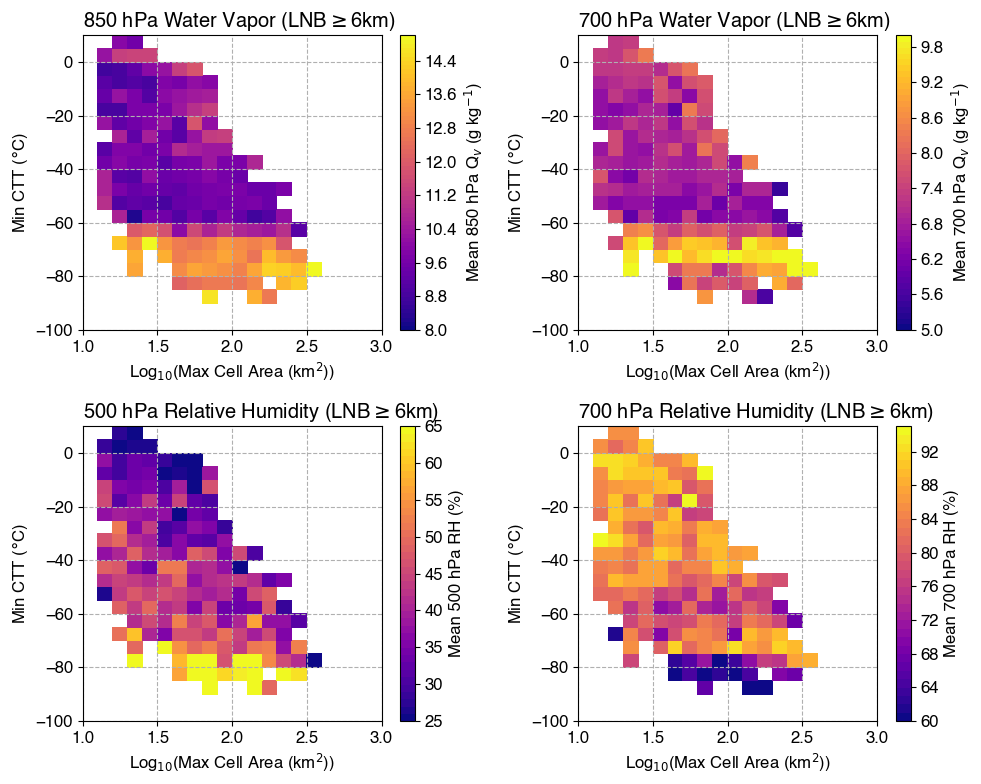

In [75]:
data_arr = [[q850pLNB6km_cellareactt_avg, q700pLNB6km_cellareactt_avg], 
            [rh500pLNB6km_cellareactt_avg, rh700pLNB6km_cellareactt_avg]]
xbins = [[bin_cellarea, bin_cellarea],[bin_cellarea, bin_cellarea]]
ybins = [[bin_ctt, bin_ctt], [bin_ctt, bin_ctt]]
levels = [[np.arange(8, 15.01, 0.1), np.arange(5, 10.01, 0.1)], 
          [np.arange(25, 65.1, 1), np.arange(60, 95.01, 1)]]
cmap = 'plasma'
xlabels = [['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))'], 
           ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))']]
ylabels = [['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)'], 
           ['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)']]
titles = [[f'850 hPa Water Vapor (LNB$\geq$6km)', f'700 hPa Water Vapor (LNB$\geq$6km)'], 
          [f'500 hPa Relative Humidity (LNB$\geq$6km)', f'700 hPa Relative Humidity (LNB$\geq$6km)']]
cblabels = [['Mean 850 hPa Q$_v$ (g kg$^{-1}$)', 'Mean 700 hPa Q$_v$ (g kg$^{-1}$)'], 
            ['Mean 500 hPa RH (%)', 'Mean 700 hPa RH (%)']]
figname = f'{figdir_jointhist}HumidityStats_LNB6km_MaxArea+MinCTT.png'
fig = plot_filledjointhist_2x2(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cblabels, figname)

In [76]:
def plot_filledjointhist_3x2(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cblabels, figname):

    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['figure.facecolor'] = 'white'
    fig, axes = plt.subplots(3, 2, figsize=(10, 12), dpi=100)

    for row in range(3):
        for col in range(2):
            ax = axes[row, col]
#             Zm = np.ma.masked_where(data_arr[row][col] <= 0, data_arr[row][col])
            Zm = np.ma.masked_invalid(data_arr[row][col])
            # Normalize colormap
            cmap = plt.get_cmap(cmap)
            norm = mpl.colors.BoundaryNorm(levels[row][col], ncolors=cmap.N)
            pcm = ax.pcolormesh(xbins[row][col], ybins[row][col], Zm, norm=norm, cmap=cmap)
            cb = plt.colorbar(pcm, ax=ax, label=cblabels[row][col])
            ax.grid(ls='--')
            ax.set_xlabel(xlabels[row][col])
            ax.set_ylabel(ylabels[row][col])
            ax.set_title(titles[row][col], loc='left')
    
    fig.tight_layout()
    fig.savefig(figname, bbox_inches='tight', dpi=300)
    
    return fig

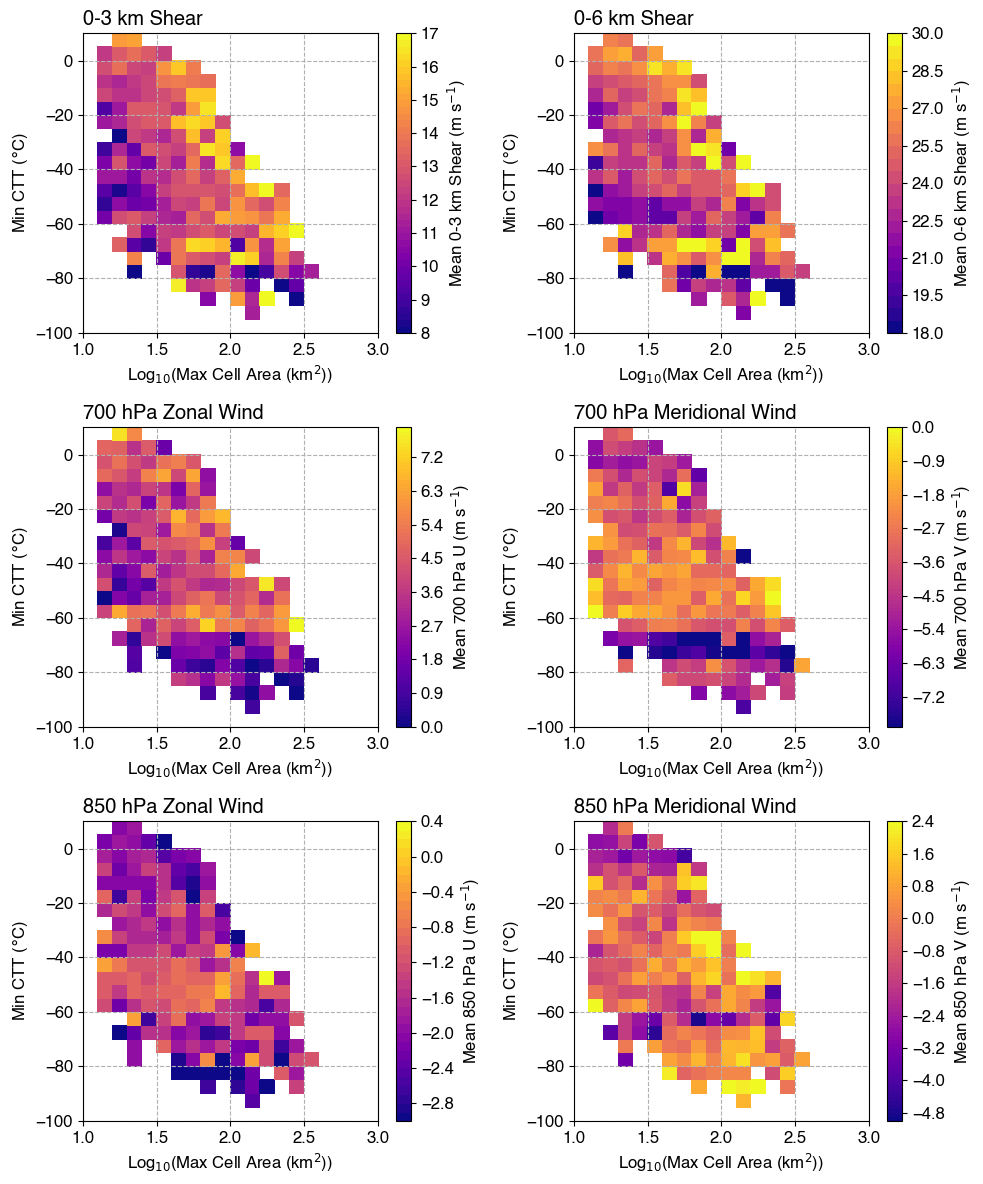

In [77]:
data_arr = [[shear3mag_cellareactt_avg, shear6mag_cellareactt_avg], 
            [u700p_cellareactt_avg, v700p_cellareactt_avg],
            [u850p_cellareactt_avg, v850p_cellareactt_avg]]
xbins = [[bin_cellarea, bin_cellarea],[bin_cellarea, bin_cellarea],[bin_cellarea, bin_cellarea]]
ybins = [[bin_ctt, bin_ctt], [bin_ctt, bin_ctt], [bin_ctt, bin_ctt]]
levels = [[np.arange(8, 17.01, 0.2), np.arange(18, 30.01, 0.5)], 
          [np.arange(0, 8.1, 0.1), np.arange(-8.0, 0.01, 0.1)],
          [np.arange(-3, 0.5, 0.1), np.arange(-5, 2.5, 0.1)]]
cmap = 'plasma'
xlabels = [['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))'], 
           ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))'],
           ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))']]
ylabels = [['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)'], 
           ['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)'],
           ['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)']]
titles = [['0-3 km Shear', '0-6 km Shear'], 
          ['700 hPa Zonal Wind', '700 hPa Meridional Wind'],
          ['850 hPa Zonal Wind', '850 hPa Meridional Wind']]
cblabels = [['Mean 0-3 km Shear (m s$^{-1}$)', 'Mean 0-6 km Shear (m s$^{-1}$)'], 
            ['Mean 700 hPa U (m s$^{-1}$)', 'Mean 700 hPa V (m s$^{-1}$)'],
            ['Mean 850 hPa U (m s$^{-1}$)', 'Mean 850 hPa V (m s$^{-1}$)']]
figname = f'{figdir_jointhist}WindStats_MaxArea+MinCTT.png'
fig = plot_filledjointhist_3x2(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cblabels, figname)

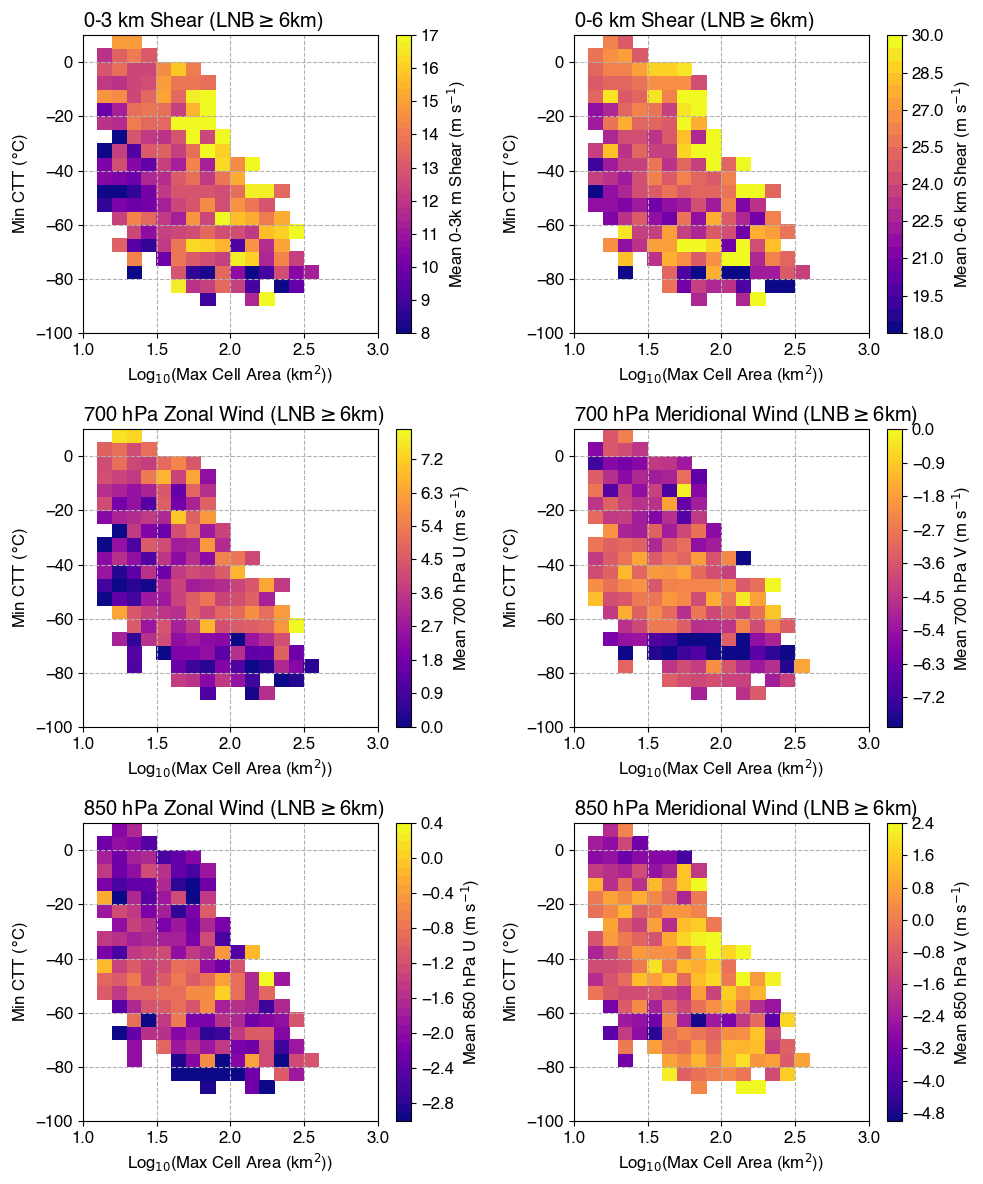

In [78]:
data_arr = [[shear3magLNB6km_cellareactt_avg, shear6magLNB6km_cellareactt_avg], 
            [u700pLNB6km_cellareactt_avg, v700pLNB6km_cellareactt_avg],
            [u850pLNB6km_cellareactt_avg, v850pLNB6km_cellareactt_avg]]
xbins = [[bin_cellarea, bin_cellarea],[bin_cellarea, bin_cellarea],[bin_cellarea, bin_cellarea]]
ybins = [[bin_ctt, bin_ctt], [bin_ctt, bin_ctt], [bin_ctt, bin_ctt]]
levels = [[np.arange(8, 17.01, 0.2), np.arange(18, 30.01, 0.5)], 
          [np.arange(0, 8.1, 0.1), np.arange(-8.0, 0.01, 0.1)],
          [np.arange(-3, 0.5, 0.1), np.arange(-5, 2.5, 0.1)]]
cmap = 'plasma'
xlabels = [['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))'], 
           ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))'],
           ['Log$_{10}$(Max Cell Area (km$^2$))', 'Log$_{10}$(Max Cell Area (km$^2$))']]
ylabels = [['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)'], 
           ['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)'],
           ['Min CTT ($\degree$C)', 'Min CTT ($\degree$C)']]
titles = [[r'0-3 km Shear (LNB$\geq$6km)', '0-6 km Shear (LNB$\geq$6km)'], 
          ['700 hPa Zonal Wind (LNB$\geq$6km)', '700 hPa Meridional Wind (LNB$\geq$6km)'],
          ['850 hPa Zonal Wind (LNB$\geq$6km)', '850 hPa Meridional Wind (LNB$\geq$6km)']]
cblabels = [['Mean 0-3k m Shear (m s$^{-1}$)', 'Mean 0-6 km Shear (m s$^{-1}$)'], 
            ['Mean 700 hPa U (m s$^{-1}$)', 'Mean 700 hPa V (m s$^{-1}$)'],
            ['Mean 850 hPa U (m s$^{-1}$)', 'Mean 850 hPa V (m s$^{-1}$)']]
figname = f'{figdir_jointhist}WindStats_LNB6km_MaxArea+MinCTT.png'
fig = plot_filledjointhist_3x2(data_arr, xbins, ybins, levels, cmap, xlabels, ylabels, titles, cblabels, figname)

In [79]:
figdir

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1/figures/celltrack_environment_stats/'

In [80]:
# Find equal sample number bin values by quantiles
quantile_bins = [0,0.33,0.66,1]
cape_qcut, cape_bins = pd.qcut(cape_lnb6km, quantile_bins, retbins=True)
shear6mag_qcut, shear6mag_bins = pd.qcut(shear6mag_lnb6km, quantile_bins, retbins=True)
cape_bins = np.array(cape_bins)
shear6mag_bins = np.array(shear6mag_bins)
print(cape_bins)

cape_range = cape_bins
shear6mag_range = shear6mag_bins

lifetime_lnb6km = lifetime.where(lnb_z >= 6)
# max_dbz_lifetime_lnb6km = 

nsamples_capeshear6mag, lifetime_capeshear6mag_pts, \
lifetime_capeshear6mag_avg = quantiles1d_by2cond(lifetime_lnb6km, cape_lnb6km, cape_range, shear6mag_lnb6km, shear6mag_range,
                                                 start_lon, lon_eSDC, quantiles_2d)

nsamples_capeshear6mag, cell_area_capeshear6mag_pts, \
cell_area_capeshear6mag_avg = quantiles2d_by2cond(stats.cell_area.where(lnb_z >= 6), cape_lnb6km, cape_range, shear6mag_lnb6km, shear6mag_range,
                                                  start_lon, lon_eSDC, quantiles_2d)

nsamples_capeshear6mag, max_cellarea_capeshear6mag_pts, \
max_cellarea_capeshear6mag_avg = quantiles1d_by2cond(max_cellarea_lifetime_lnb6km, cape_lnb6km, cape_range, shear6mag_lnb6km, shear6mag_range,
                                                  start_lon, lon_eSDC, quantiles_2d)

nsamples_capeshear6mag, minctt_capeshear6mag_pts, \
minctt_capeshear6mag_avg = quantiles1d_by2cond(min_ctt_lifetime_lnb6km, cape_lnb6km, cape_range, shear6mag_lnb6km, shear6mag_range,
                                                  start_lon, lon_eSDC, quantiles_2d)

nsamples_capeshear6mag, max_dbz_capeshear6mag_pts, \
max_dbz_capeshear6mag_avg = quantiles1d_by2cond(max_dbz_lifetime_lnb6km, cape_lnb6km, cape_range, shear6mag_lnb6km, shear6mag_range,
                                                  start_lon, lon_eSDC, quantiles_2d)

nsamples_capeshear6mag, max_eth30_capeshear6mag_pts, \
max_eth30_capeshear6mag_avg = quantiles1d_by2cond(max_eth30_lifetime_lnb6km, cape_lnb6km, cape_range, shear6mag_lnb6km, shear6mag_range,
                                                  start_lon, lon_eSDC, quantiles_2d)

[1.35800064e+00 3.15111359e+02 1.00709027e+03 7.23646094e+03]


In [81]:
def plot_filledjointhist(data_arr, sample_arr, qntl, ticklabels, xlabel, ylabel, title, cblabel, figname):

    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['figure.facecolor'] = 'white'
    fig, axes = plt.subplots(1, 1, figsize=(6, 5), dpi=150)

    ax1 = axes
    # plt.pcolormesh(cape_range, shear6mag_range, np.log10(cell_area_capeshear6mag_pts[idx,:,:]))
    pcm1 = ax1.pcolormesh(data_arr, cmap=cmap)
    # pcm1 = ax1.pcolormesh((cell_area_capeshear6mag_pts[idx,:,:]))
    cb1 = plt.colorbar(pcm1, ax=ax1, label=cblabel)
    ax1.set_xticks(np.arange(len(ticklabels)))
    ax1.set_yticks(np.arange(len(ticklabels)))
    ax1.set_xticklabels(ticklabels)
    ax1.set_yticklabels(ticklabels)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    for (i, j), z in np.ndenumerate(sample_arr):
        ax1.text(j+0.5, i+0.5, '{:0.0f}'.format(z), ha='center', va='center', color='white', fontsize=10)
    ax1.set_title(title, loc='left')
    ax1.text(0.02, 0.04, f'Sample (#)', ha='left', color='white', transform=ax1.transAxes, fontsize=10)
    
    fig.tight_layout()
#     fig.savefig(figname, bbox_inches='tight', dpi=300)
    
    return fig

In [82]:
figdir

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1/figures/celltrack_environment_stats/'

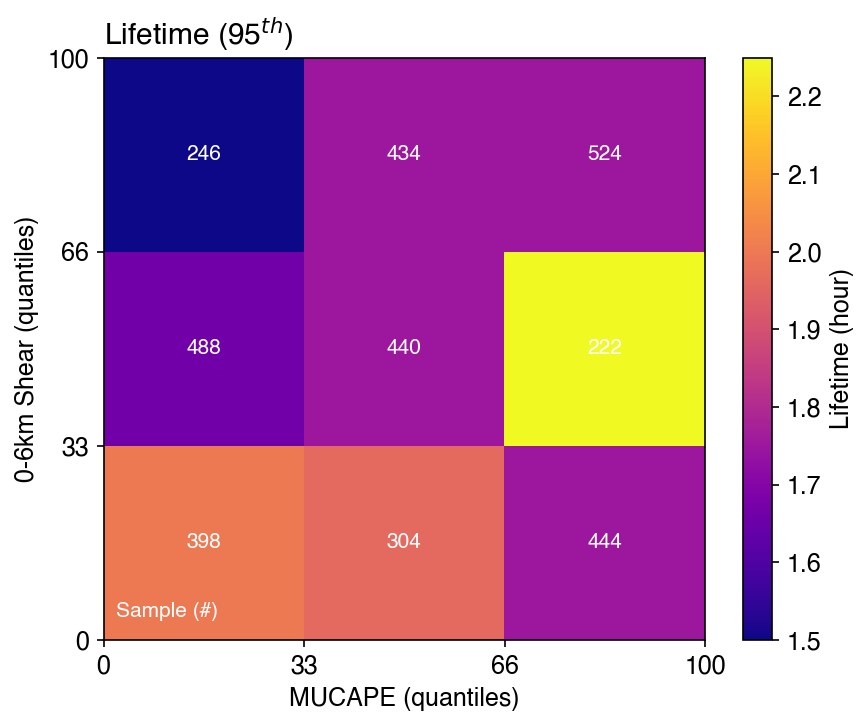

In [83]:
qntl = 0.95
# Find quantile bin index
idx = np.where(np.array(quantiles_2d) == qntl)[0].item()
data_arr = lifetime_capeshear6mag_pts[idx,:,:]
# data_arr = lifetime_capeshear6mag_avg
sample_arr = nsamples_capeshear6mag
ticklabels = (np.array(quantile_bins)*100).astype(int)
cblabel = 'Lifetime (hour)'
cmap = 'plasma'
xlabel = 'MUCAPE (quantiles)'
ylabel = '0-6km Shear (quantiles)'
title = f'Lifetime ({qntl*100:.0f}'+'$^{th}$)'
figname = f'{figdir}celllifetime_filledjointhist_MUCAPE_Shear0-6km.png'
fig = plot_filledjointhist(data_arr, sample_arr, qntl, ticklabels, xlabel, ylabel, title, cblabel, figname)

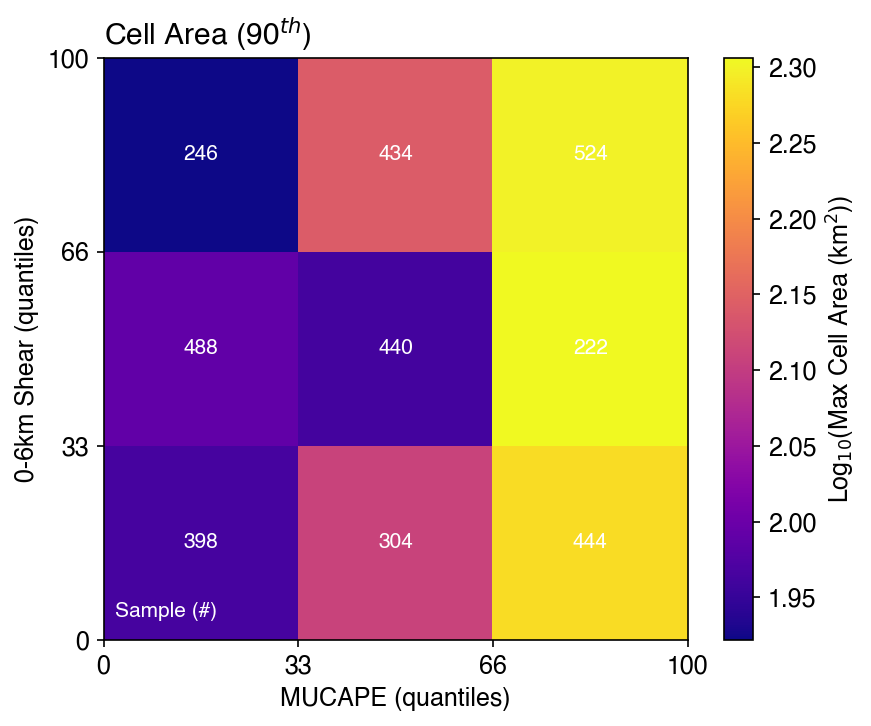

In [84]:
qntl = 0.9
# Find quantile bin index
idx = np.where(np.array(quantiles_2d) == qntl)[0].item()
data_arr = np.log10(cell_area_capeshear6mag_pts[idx,:,:])
# data_arr = cell_area_capeshear6mag_avg
sample_arr = nsamples_capeshear6mag
ticklabels = (np.array(quantile_bins)*100).astype(int)
cblabel = 'Log$_{10}$(Max Cell Area (km$^2$))'
cmap = 'plasma'
xlabel = 'MUCAPE (quantiles)'
ylabel = '0-6km Shear (quantiles)'
title = f'Cell Area ({qntl*100:.0f}'+'$^{th}$)'
figname = f'{figdir}cellarea_filledjointhist_MUCAPE_Shear0-6km.png'
fig = plot_filledjointhist(data_arr, sample_arr, qntl, ticklabels, xlabel, ylabel, title, cblabel, figname)

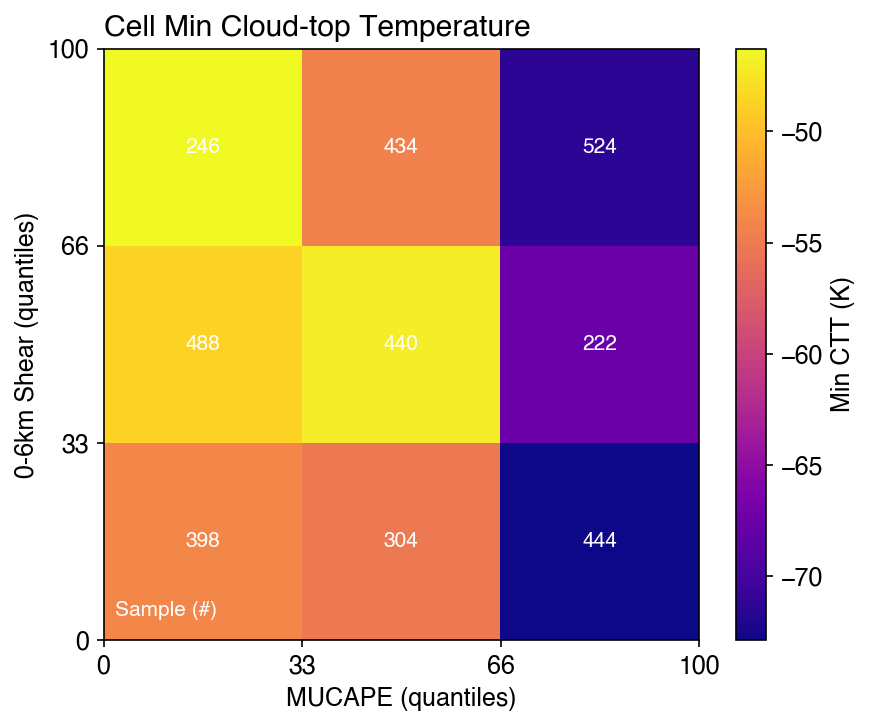

In [85]:
qntl = 0.25
# Find quantile bin index
idx = np.where(np.array(quantiles_2d) == qntl)[0].item()
data_arr = minctt_capeshear6mag_pts[idx,:,:]
# data_arr = minctt_capeshear6mag_avg
sample_arr = nsamples_capeshear6mag
ticklabels = (np.array(quantile_bins)*100).astype(int)
cblabel = 'Min CTT (K)'
cmap = 'plasma'
xlabel = 'MUCAPE (quantiles)'
ylabel = '0-6km Shear (quantiles)'
# title = f'Min CTT ({qntl*100:.0f}'+'$^{th}$)'
title = f'Cell Min Cloud-top Temperature'
figname = f'{figdir}CellMinCTT_filledjointhist_MUCAPE_Shear0-6km.png'
fig = plot_filledjointhist(data_arr, sample_arr, qntl, ticklabels, xlabel, ylabel, title, cblabel, figname)

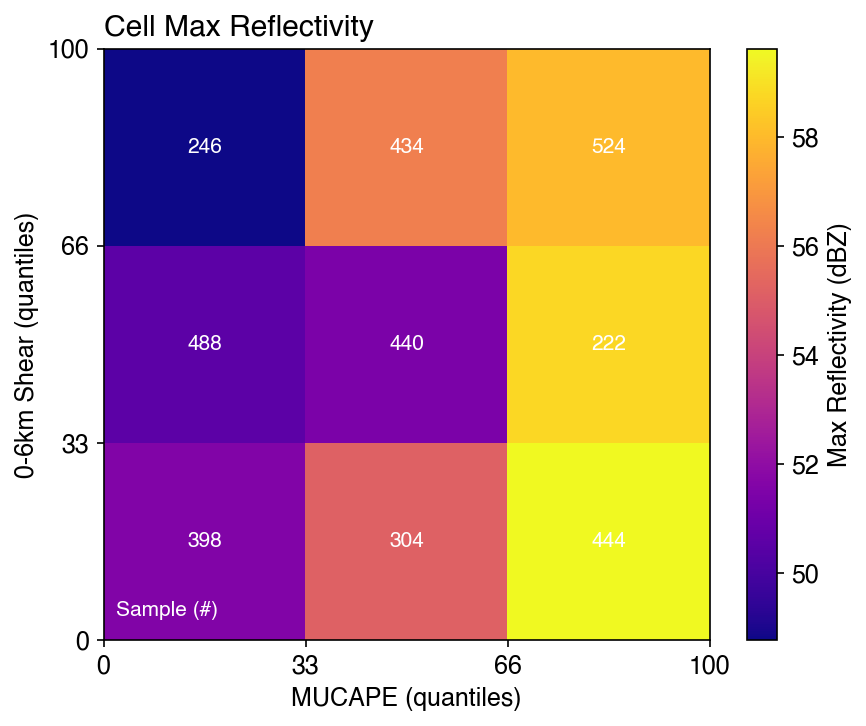

In [86]:
qntl = 0.9
# Find quantile bin index
idx = np.where(np.array(quantiles_2d) == qntl)[0].item()
data_arr = max_dbz_capeshear6mag_pts[idx,:,:]
# data_arr = minctt_capeshear6mag_avg
sample_arr = nsamples_capeshear6mag
ticklabels = (np.array(quantile_bins)*100).astype(int)
cblabel = 'Max Reflectivity (dBZ)'
cmap = 'plasma'
xlabel = 'MUCAPE (quantiles)'
ylabel = '0-6km Shear (quantiles)'
# title = f'Min CTT ({qntl*100:.0f}'+'$^{th}$)'
title = f'Cell Max Reflectivity'
figname = f'{figdir}CellMaxDBZ_filledjointhist_MUCAPE_Shear0-6km.png'
fig = plot_filledjointhist(data_arr, sample_arr, qntl, ticklabels, xlabel, ylabel, title, cblabel, figname)

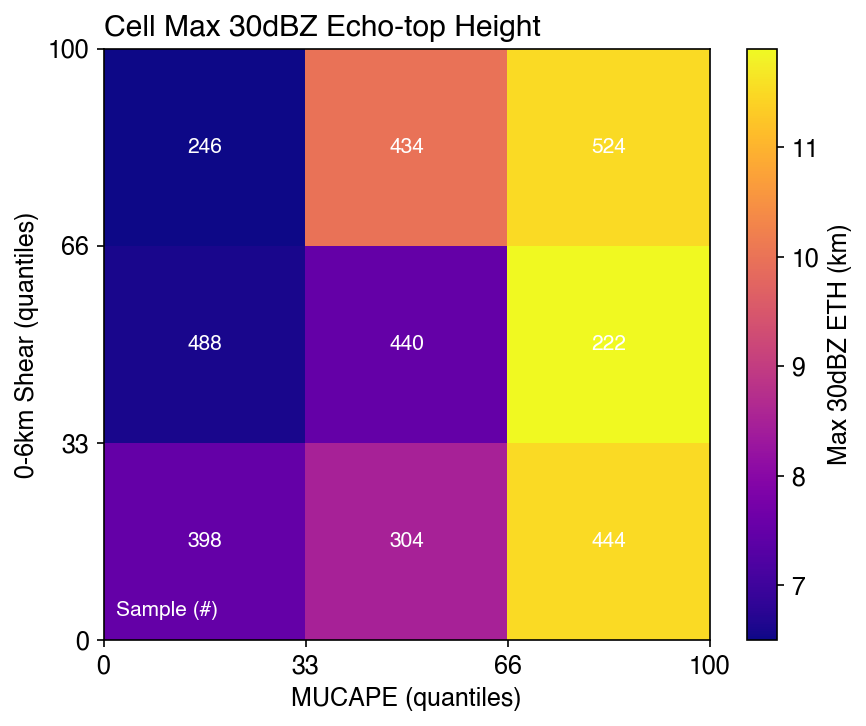

In [87]:
qntl = 0.9
# Find quantile bin index
idx = np.where(np.array(quantiles_2d) == qntl)[0].item()
data_arr = max_eth30_capeshear6mag_pts[idx,:,:]
sample_arr = nsamples_capeshear6mag
ticklabels = (np.array(quantile_bins)*100).astype(int)
cblabel = 'Max 30dBZ ETH (km)'
cmap = 'plasma'
xlabel = 'MUCAPE (quantiles)'
ylabel = '0-6km Shear (quantiles)'
# title = f'Min CTT ({qntl*100:.0f}'+'$^{th}$)'
title = f'Cell Max 30dBZ Echo-top Height'
figname = f'{figdir}CellMaxETH30dBZ_filledjointhist_MUCAPE_Shear0-6km.png'
fig = plot_filledjointhist(data_arr, sample_arr, qntl, ticklabels, xlabel, ylabel, title, cblabel, figname)

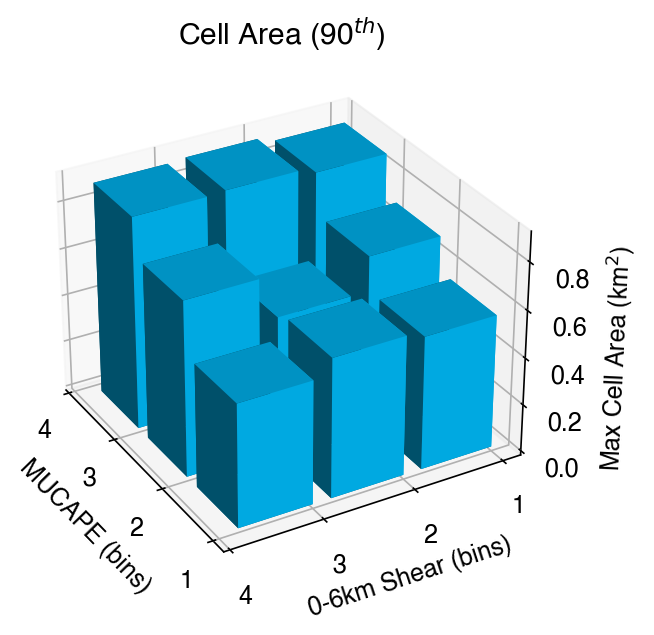

In [88]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['figure.facecolor'] = 'white'

fig = plt.figure(figsize=(10, 10), dpi=150)
ax1 = fig.add_subplot(121, projection='3d')

_x = np.arange(len(cape_bins)-1)+1
_y = np.arange(len(shear6mag_bins)-1)+1
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

# top = nsamples_capeshear6mag.ravel()
qntl = 0.9
# Find quantile bin index
idx = np.where(np.array(quantiles_2d) == qntl)[0].item()
top = max_cellarea_capeshear6mag_pts[idx,:,:].ravel()
top = top-1.4
# top = cell_area_capeshear6mag_pts[idx,:,:].ravel()
# top = cell_area_capeshear6mag_avg.ravel()
# top = top - 1.5
bottom = np.zeros_like(top)
width = depth = 0.8

ax1.bar3d(x, y, bottom, width, depth, top, shade=True, color='deepskyblue')
ax1.view_init(30, 150)
# ax1.set_xlim3d(0,4)
# ax1.set_ylim3d(0,4)
ax1.set_xticks(np.arange(1,5))
ax1.set_yticks(np.arange(1,5))
# ax1.set_xticklabels(cape_range)
# ax1.set_yticklabels(shear6mag_range)
xlabel = 'MUCAPE (bins)'
ylabel = '0-6km Shear (bins)'
zlabel = 'Max Cell Area (km$^2$)'
ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)
ax1.set_zlabel(zlabel)
ax1.set_title(f'Cell Area ({qntl*100:.0f}'+'$^{th}$)')
fig.savefig(f'{figdir_jointhist}MaxArea_MUCAPE_Shear0-6km_3Dbar.png', bbox_inches='tight', dpi=300)

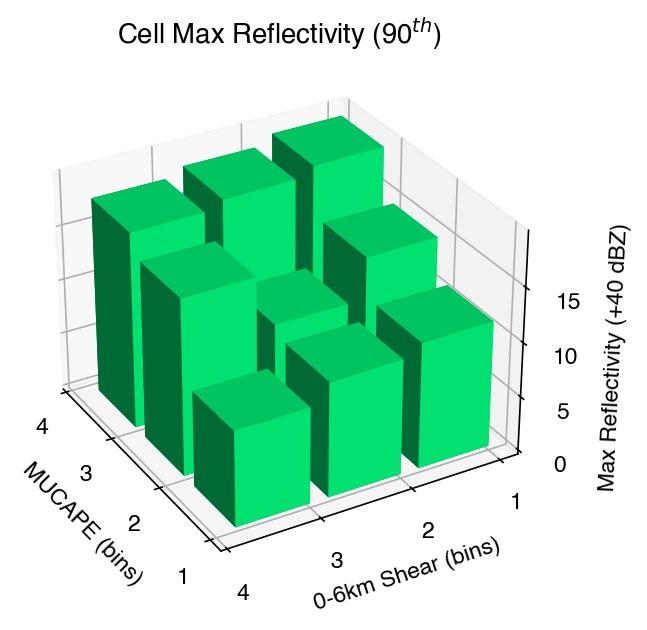

In [89]:
mpl.rcParams['font.size'] = 11
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['figure.facecolor'] = 'white'

fig = plt.figure(figsize=(10, 10), dpi=150)
ax1 = fig.add_subplot(121, projection='3d')

_x = np.arange(len(cape_bins)-1)+1
_y = np.arange(len(shear6mag_bins)-1)+1
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

qntl = 0.9
# Find quantile bin index
idx = np.where(np.array(quantiles_2d) == qntl)[0].item()
top = max_dbz_capeshear6mag_pts[idx,:,:].ravel()
top = top - 40
bottom = np.zeros_like(top)
width = depth = 0.8

ax1.bar3d(x, y, bottom, width, depth, top, shade=True, color='springgreen')
ax1.view_init(30, 150)
# ax1.set_xlim3d(0,4)
# ax1.set_ylim3d(0,4)
ax1.set_xticks(np.arange(1,5))
ax1.set_yticks(np.arange(1,5))
# ax1.set_xticklabels(cape_range)
# ax1.set_yticklabels(shear6mag_range)
xlabel = 'MUCAPE (bins)'
ylabel = '0-6km Shear (bins)'
zlabel = 'Max Reflectivity (+40 dBZ)'
ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)
ax1.set_zlabel(zlabel)
ax1.set_title(f'Cell Max Reflectivity ({qntl*100:.0f}'+'$^{th}$)')
fig.savefig(f'{figdir_jointhist}MaxDBZ_MUCAPE_Shear0-6km_3Dbar.png', bbox_inches='tight', dpi=300)

In [90]:
minctt_capeshear6mag_avg

array([[-41.03100967, -45.07273865, -55.5830307 ],
       [-30.17071152, -26.66765213, -46.73580551],
       [-31.5964222 , -37.17034531, -49.8109436 ]])

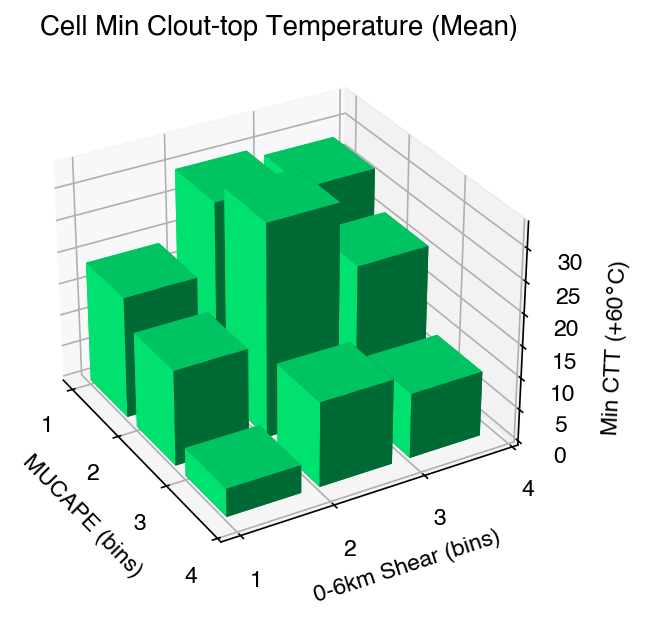

In [91]:
mpl.rcParams['font.size'] = 11
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['figure.facecolor'] = 'white'

fig = plt.figure(figsize=(10, 10), dpi=150)
ax1 = fig.add_subplot(121, projection='3d')

_x = np.arange(len(cape_bins)-1)+1
_y = np.arange(len(shear6mag_bins)-1)+1
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

# top = nsamples_capeshear6mag.ravel()
qntl = 0.25
# Find quantile bin index
idx = np.where(np.array(quantiles_2d) == qntl)[0].item()
# top = minctt_capeshear6mag_pts[idx,:,:].ravel()
# top = top-100
top = minctt_capeshear6mag_avg.ravel()
top = top+60
# top = cell_area_capeshear6mag_avg.ravel()
bottom = np.zeros_like(top)
width = depth = 0.8

ax1.bar3d(x, y, bottom, width, depth, top, shade=True, color='springgreen')
ax1.view_init(30, -30)
# ax1.set_xlim3d(0,4)
# ax1.set_ylim3d(0,4)
ax1.set_xticks(np.arange(1,5))
ax1.set_yticks(np.arange(1,5))
# ax1.set_xticklabels(cape_range)
# ax1.set_yticklabels(shear6mag_range)
xlabel = 'MUCAPE (bins)'
ylabel = '0-6km Shear (bins)'
zlabel = 'Min CTT (+60$\degree$C)'
ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)
ax1.set_zlabel(zlabel)
# ax1.set_title(f'Cell Min Clout-top Temperature ({qntl*100:.0f}'+'$^{th}$)')
ax1.set_title(f'Cell Min Clout-top Temperature (Mean)')
fig.savefig(f'{figdir_jointhist}MinCTT_MUCAPE_Shear0-6km_3Dbar.png', bbox_inches='tight', dpi=300)

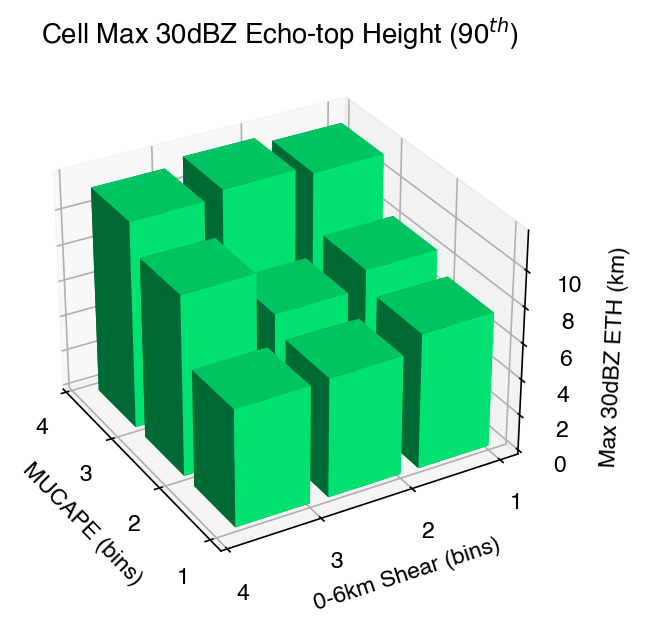

In [92]:
mpl.rcParams['font.size'] = 11
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['figure.facecolor'] = 'white'

fig = plt.figure(figsize=(10, 10), dpi=150)
ax1 = fig.add_subplot(121, projection='3d')

_x = np.arange(len(cape_bins)-1)+1
_y = np.arange(len(shear6mag_bins)-1)+1
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

qntl = 0.9
# Find quantile bin index
idx = np.where(np.array(quantiles_2d) == qntl)[0].item()
top = max_eth30_capeshear6mag_pts[idx,:,:].ravel()
top = top
bottom = np.zeros_like(top)
width = depth = 0.8

ax1.bar3d(x, y, bottom, width, depth, top, shade=True, color='springgreen')
ax1.view_init(30, 150)
ax1.set_xticks(np.arange(1,5))
ax1.set_yticks(np.arange(1,5))
xlabel = 'MUCAPE (bins)'
ylabel = '0-6km Shear (bins)'
zlabel = 'Max 30dBZ ETH (km)'
ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)
ax1.set_zlabel(zlabel)
ax1.set_title(f'Cell Max 30dBZ Echo-top Height ({qntl*100:.0f}'+'$^{th}$)')
fig.savefig(f'{figdir_jointhist}MaxETH30dBZ_MUCAPE_Shear0-6km_3Dbar.png', bbox_inches='tight', dpi=300)

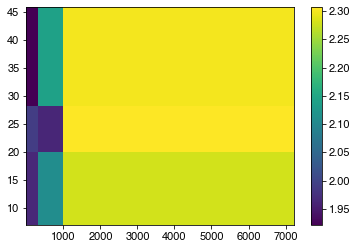

In [93]:
qntl = 0.9
idx = np.where(np.array(quantiles_2d) == qntl)[0]
plt.pcolormesh(cape_range, shear6mag_range, np.log10(cell_area_capeshear6mag_pts[idx,:,:]).squeeze())
plt.colorbar()

In [94]:
cape_range

array([1.35800064e+00, 3.15111359e+02, 1.00709027e+03, 7.23646094e+03])